## Drowsiness Detection Problem

Requirements:
opencv-python
numpy
torch
torchprofile
matplotlib
torchvision
tqdm
scikit-learn

# Import libraries

In [1]:
import cv2
import os
from collections import defaultdict, OrderedDict
import numpy as np
import random
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader,random_split,Subset,TensorDataset
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm
from torch.utils.data import ConcatDataset
import torchvision.models as models
import torchvision
from torchprofile import profile_macs
from sklearn.metrics import confusion_matrix,precision_score, recall_score, f1_score
import time
from pygame import mixer
import copy
from typing import Union,List


pygame 2.6.1 (SDL 2.28.4, Python 3.9.21)
Hello from the pygame community. https://www.pygame.org/contribute.html


Fix the randomness

In [2]:
seed=0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [4]:
print( torch.cuda.is_available())

True


# Data preprocessing

Image visualization

In [5]:
path='./mrleyedataset'

# Load images using ImageFolder
image_dataset = ImageFolder(root=path, transform=transforms.ToTensor())

samples={}
# Before transformation
samples['Before']=[[],[]]
for d , l in image_dataset:
    if len(samples['Before'][l])< 2 :
        samples['Before'][l].append(d)
#    print(len(samples[0]),len(samples[1]))
    if len(samples['Before'][0])==4 and len(samples['Before'][1])==4:
        break

View examples before transformation

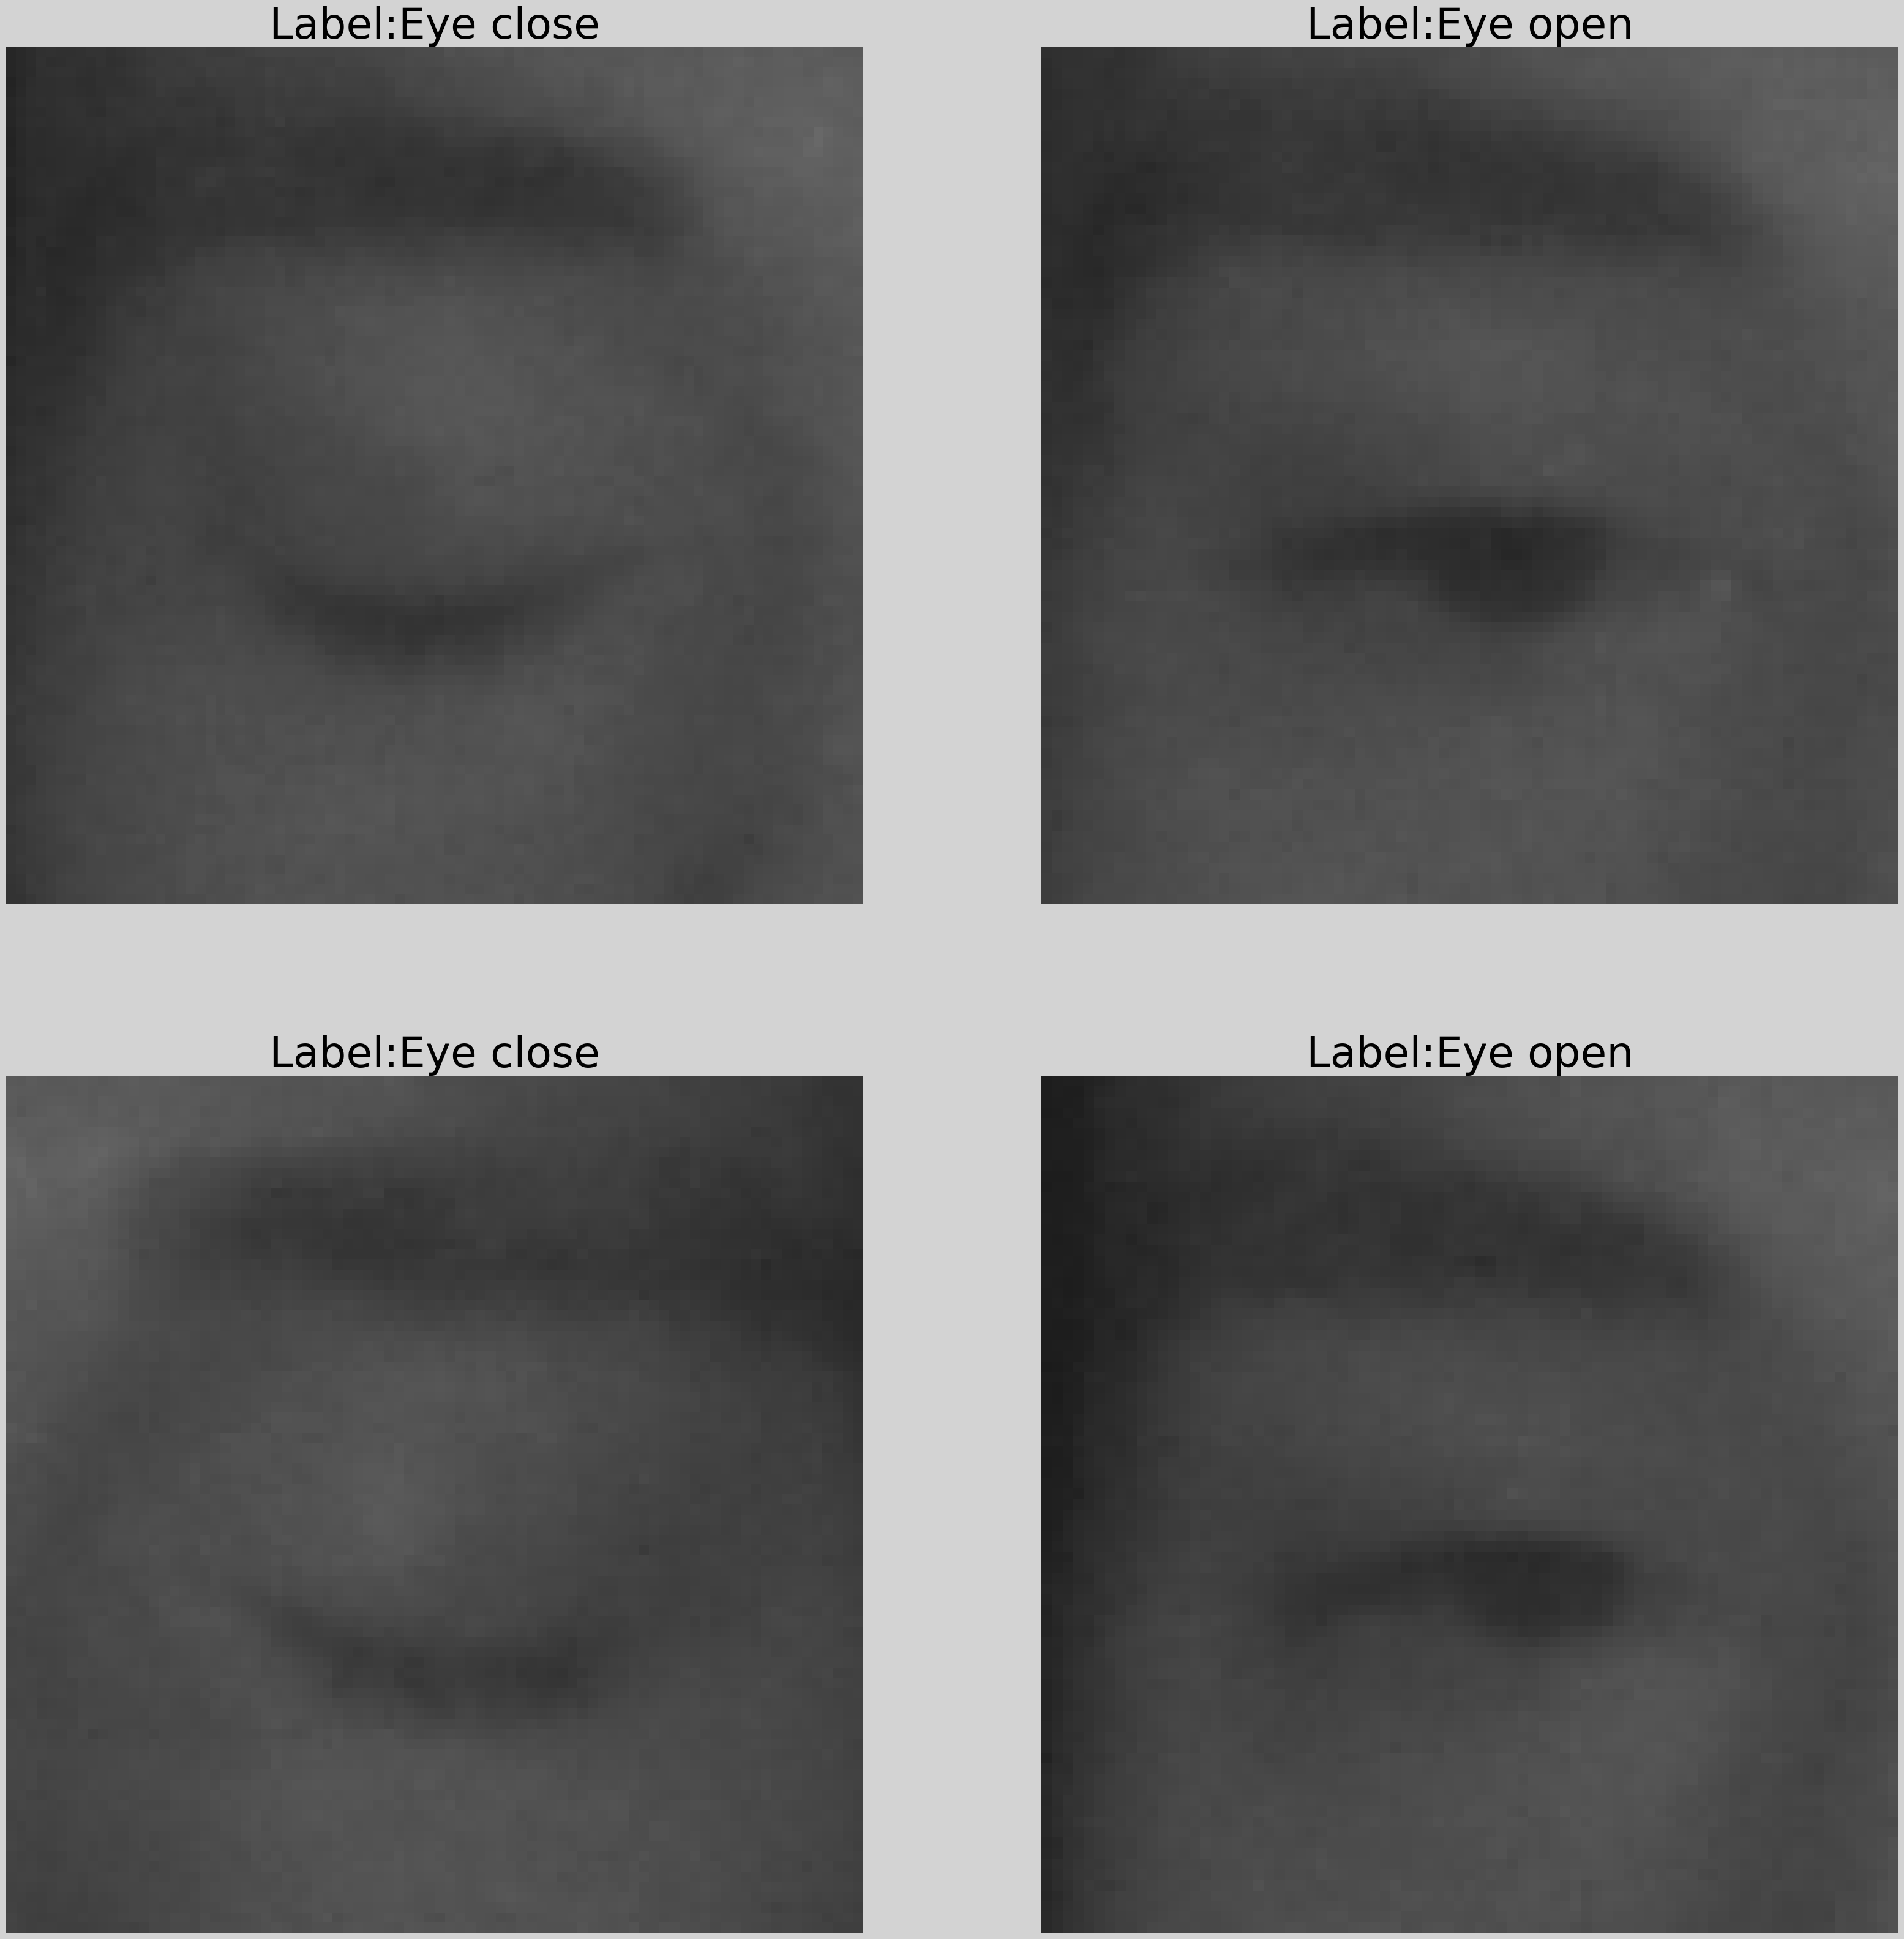

In [6]:
width=2
fig, ax = plt.subplots(2, width, figsize=(40, 40))
fig.set_facecolor('lightgrey')
e_status=['Eye close','Eye open']
for l in [0,1]:
    for i in range(2):
        image=samples['Before'][l][i]
        ax[i,l].imshow(image.permute(1, 2, 0),cmap='gray')
        ax[i,l].set_title(f"Label:{e_status[l]}", fontsize=50)
        ax[i,l].axis("off")
plt.show()


In [7]:
# Define separate transforms
train_transform = transforms.Compose([
    transforms.Resize((80, 80)),  
    transforms.RandomRotation(20),  
    transforms.RandomAffine(degrees=0, shear=20),  
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomVerticalFlip(p=0.5),  
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

test_transform = transforms.Compose([
    transforms.Resize((80, 80)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

# Load full dataset WITHOUT transform
full_dataset = ImageFolder(root=path)  

# Split dataset indices
train_size = int(0.80 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_indices, test_indices = random_split(full_dataset, [train_size, test_size])

# Create separate datasets with different transforms
train_dataset = ImageFolder(root=path, transform=train_transform)  
test_dataset = ImageFolder(root=path, transform=test_transform)  

# Apply the split indices
dataset = {
    "train": torch.utils.data.Subset(train_dataset, train_indices.indices),
    "test": torch.utils.data.Subset(test_dataset, test_indices.indices),
}

# Create DataLoaders
batch_size = 32
dataloader = {
    "train": DataLoader(dataset["train"], batch_size=batch_size, shuffle=True),
    "test": DataLoader(dataset["test"], batch_size=batch_size, shuffle=False)
}

View example images after transformation

In [8]:

# After transformation


samples['After']=[[],[]]
for d , l in dataset['train']:
    if len(samples['After'][l])< 2 :
        samples['After'][l].append(d)
#    print(len(samples[0]),len(samples[1]))
    if len(samples['After'][0])==4 and len(samples['After'][1])==4:
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..-0.14509803].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..-0.19215685].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..-0.06666666].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..-0.23137254].


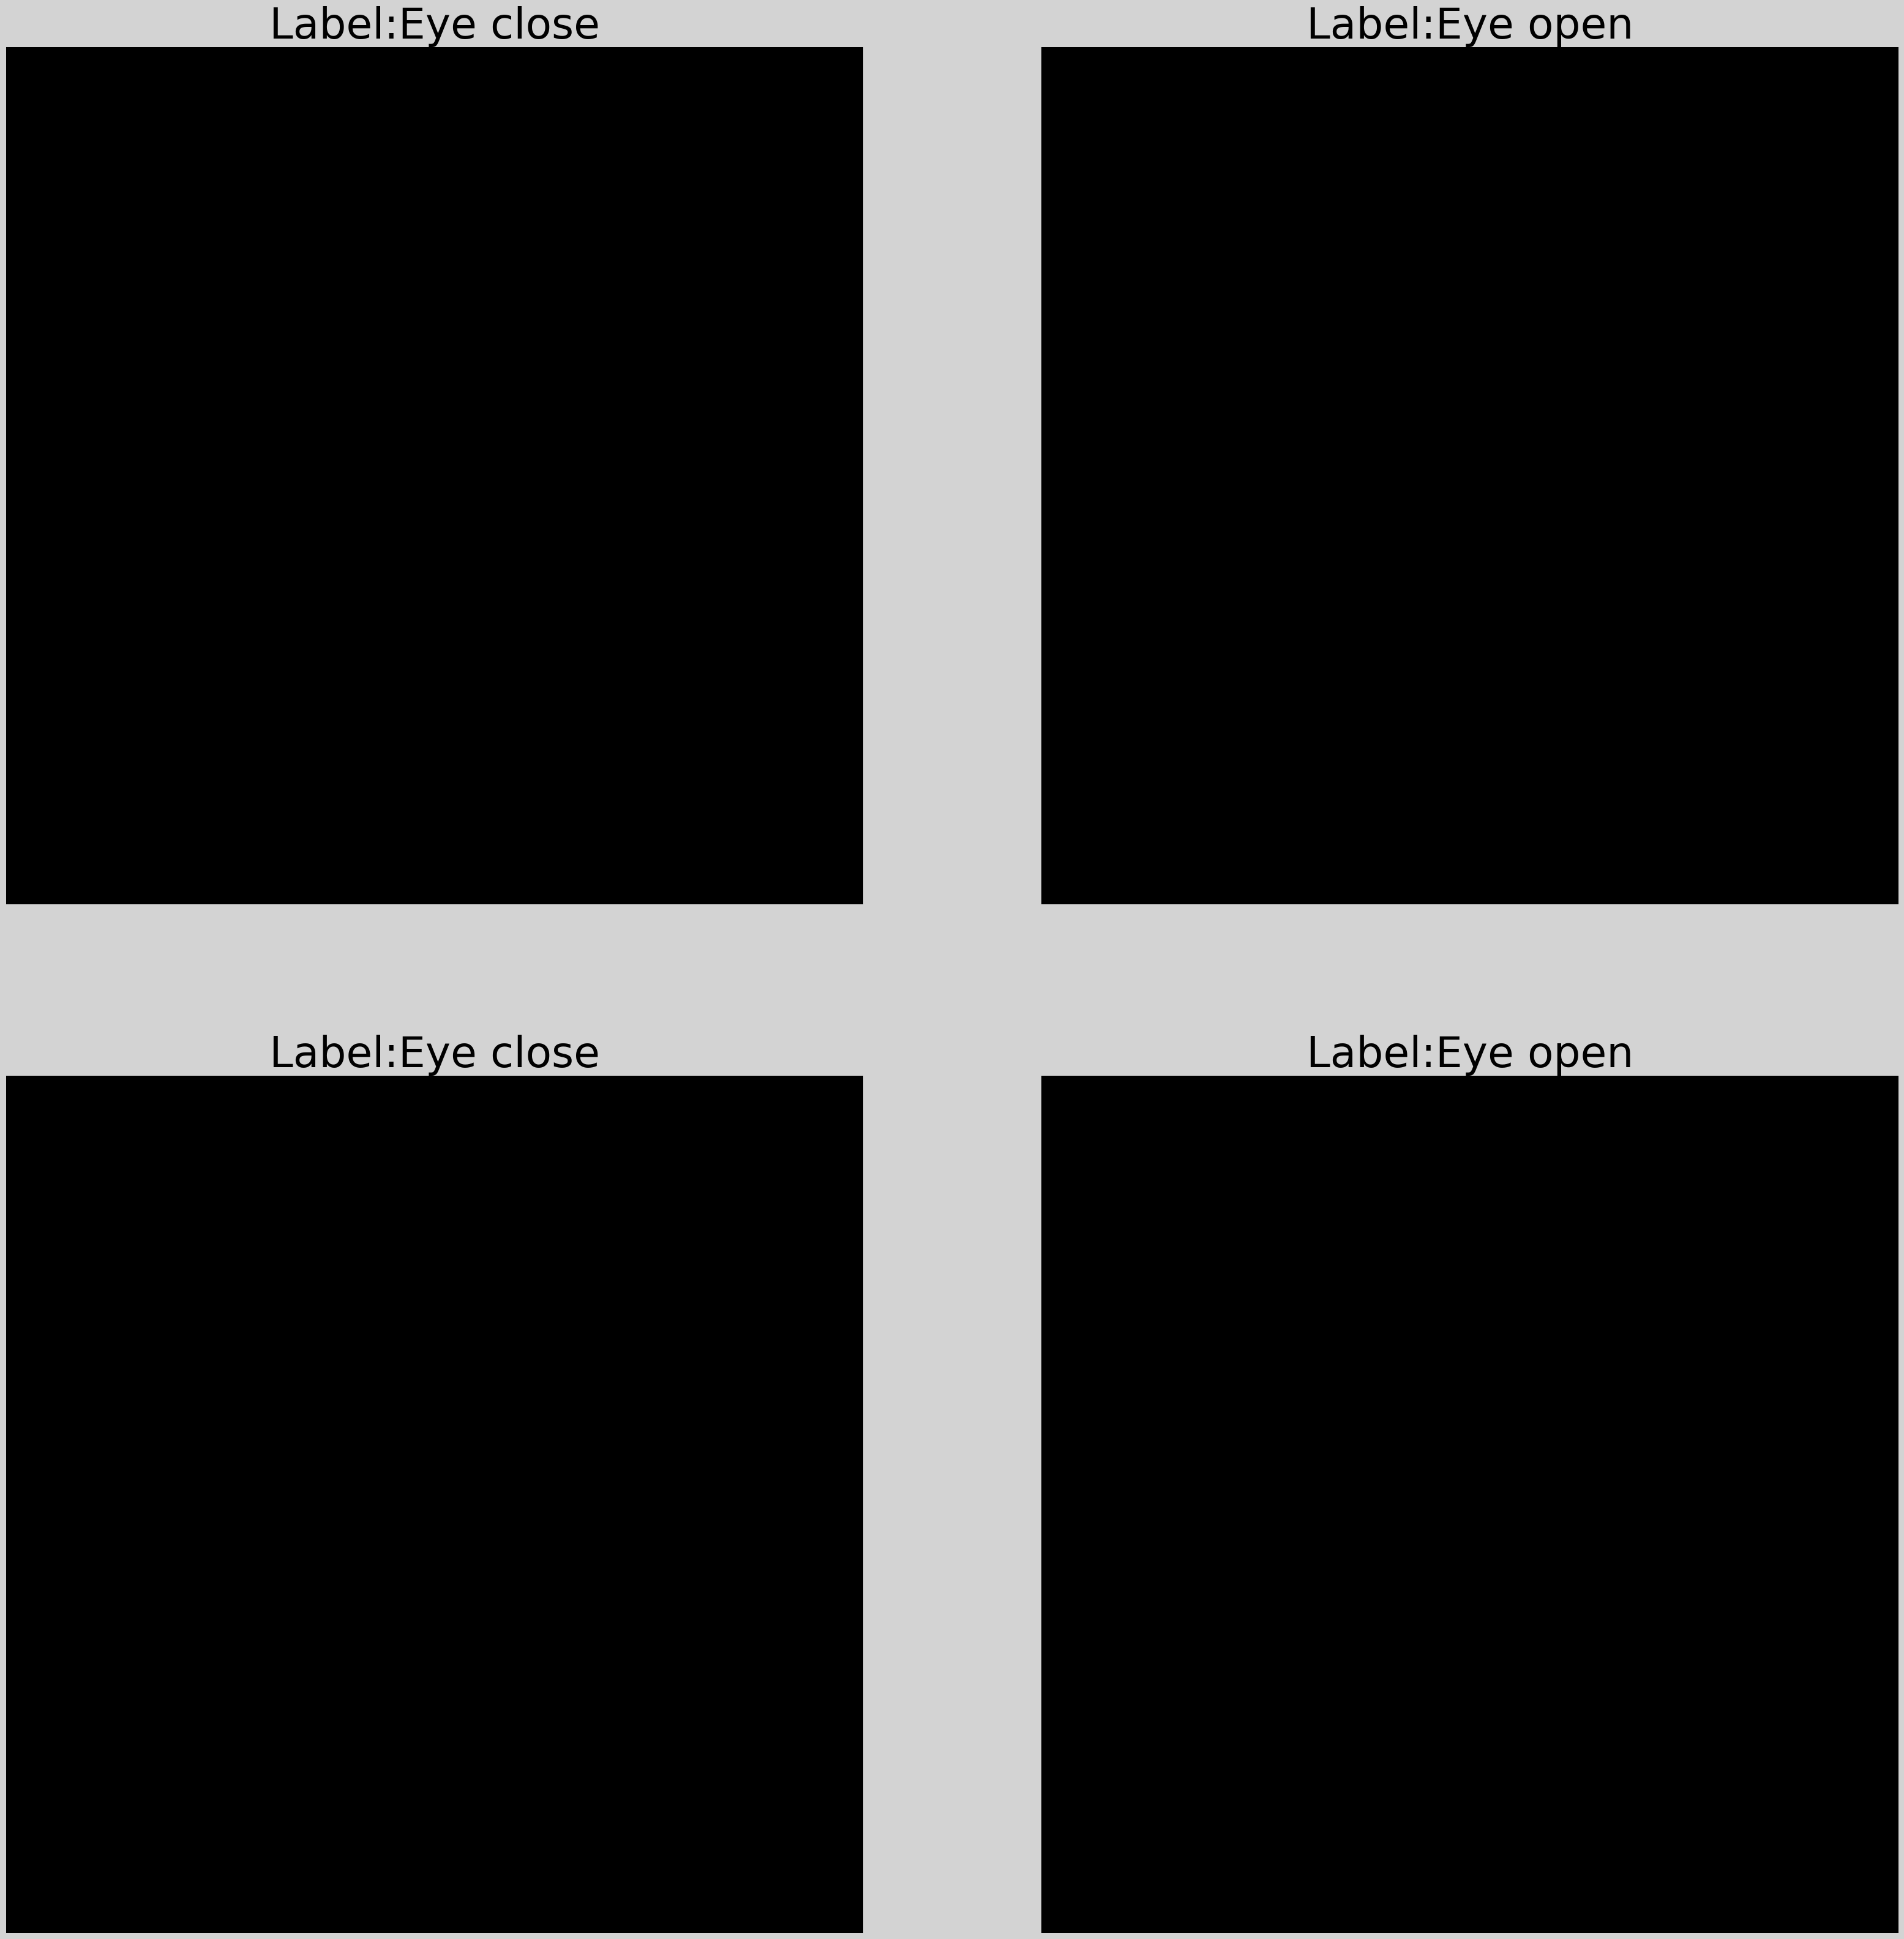

In [9]:
width=2
fig, ax = plt.subplots(2, width, figsize=(40, 40))
fig.set_facecolor('lightgrey')
e_status=['Eye close','Eye open']
for l in [0,1]:
    for i in range(2):
        image=samples['After'][l][i]
        ax[i,l].imshow(image.permute(1, 2, 0),cmap='gray')
        ax[i,l].set_title(f"Label:{e_status[l]}", fontsize=50)
        ax[i,l].axis("off")
plt.show()

## class balance in train set

In [10]:
image_label={'e_c':0,'e_o':0}
for d,l in dataset['train']:
    if l==1:
        image_label['e_o']+=1
    else:
        image_label['e_c']+=1
print(image_label)

{'e_c': 33599, 'e_o': 34319}


class balance in test set

In [13]:
image_label={'e_c':0,'e_o':0}
for d,l in dataset['test']:
    if l==1:
        image_label['e_o']+=1
    else:
        image_label['e_c']+=1
print(image_label)

{'e_c': 8347, 'e_o': 8633}


# Models definition

Vgg model

In [16]:
class VGG(nn.Module):
  ARCH = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
  # ARCH = [32 , 32, 'M', 64, 64,'M',128, 128, 'M', 256, 256, 'M', 512, 512]

  def __init__(self) -> None:
    super().__init__()

    layers = []
    counts = defaultdict(int)

    def add(name: str, layer: nn.Module) -> None:
      layers.append((f"{name}{counts[name]}", layer))
      counts[name] += 1

    in_channels = 3
    for x in self.ARCH:
      if x != 'M':
        # conv-bn-relu
        add("conv", nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
        add("bn", nn.BatchNorm2d(x))
        add("relu", nn.ReLU(True))
        in_channels = x
      else:
        # maxpool
        add("pool", nn.MaxPool2d(2))

    self.backbone = nn.Sequential(OrderedDict(layers))
#    self.fc1 = nn.Linear(2024, 500)
    self.fc2 = nn.Linear(512, 2)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # backbone: [N, 3, 32, 32] => [N, 512, 2, 2]
    x = self.backbone(x)

    # avgpool: [N, 512, 2, 2] => [N, 512]
    x = x.mean([2, 3])

    # classifier: [N, 512] => [N, 10]
#    x = self.fc1(x)
    x = self.fc2(x)
    return x

model = VGG().cuda()

# Model training

In [17]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  epoch=0,
  callbacks = None
) -> float:
  model.train()
  total_loss = 0
  for inputs, targets in tqdm(dataloader, desc=f'train epoch:{epoch}', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)

    loss = criterion(outputs, targets)
    total_loss += loss.item()


    # Backward propagation
    loss.backward()
    # Update optimizer and LR scheduler
    optimizer.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()

  return total_loss/len(dataloader)


In [18]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  criterion =None,
  verbose=True,
) :
  model.eval()
  total_loss = float(0)
  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False,
                              disable=not verbose):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Inference
    outputs1 = model(inputs)

    # Convert logits to class indices
    outputs = outputs1.argmax(dim=1)

    # Calculate loss
    if criterion is not None:
      loss = criterion(outputs1, targets)
      total_loss += loss.item()


    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item(), total_loss/len(dataloader)

Model prediction method

In [ ]:
def predict(model,input):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    input_tensor = input_tensor.to(device)

    # Make prediction
    with torch.no_grad():  # Disable gradient calculation for faster inference
        output = model(input_tensor)

    # Get predicted class
    predicted_class = torch.argmax(output, dim=1).item()
    return predicted_class

Helper Functions (Flops, Model Size calculation, etc.)
 
The computation cost can be estimated by the number of [multiply–accumulate operations (MACs)](https://en.wikipedia.org/wiki/Multiply–accumulate_operation) using [TorchProfile](https://github.com/zhijian-liu/torchprofile):

In [20]:

def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)


def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

As we are working on a classification problem, we will apply cross entropy as our loss function to optimize the model:

In [21]:
criterion = nn.CrossEntropyLoss()

Optimization will be carried out using [stochastic gradient descent (SGD) or ADAM]
1. 40X: lr:0.0001 m:0.9
2. 100X: lr:0.001 to 0.0001 m:0.9
3. 200X: lr:0.0001 m:0.9
4. 400X: lr:0.0001 m:0.9



In [22]:
# optimizer = Adam(
#   model.parameters(),
#   lr=0.0001,
#   betas=(0.9, 0.999),
#   eps=1e-08,
#   weight_decay=0.0
# )

optimizer = SGD(
  model.parameters(),
  lr=0.0001,
  momentum=0.9,
  weight_decay=5e-4,
)

The learning rate will be modulated using the following scheduler (which is adapted from [this blog series](https://myrtle.ai/learn/how-to-train-your-resnet/)):

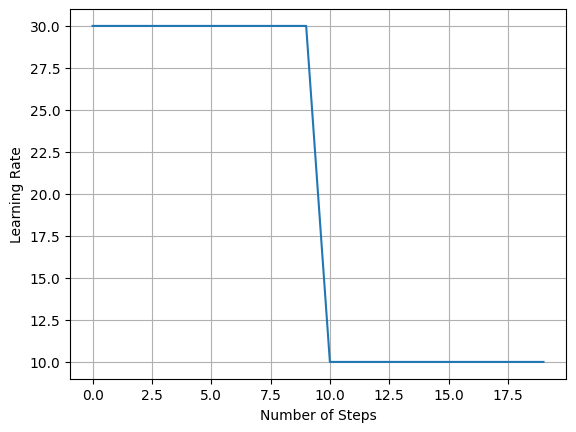

In [23]:
num_epochs = 20
steps_per_epoch = len(dataloader["train"])

# Define the piecewise linear scheduler
lr_lambda = lambda step: np.interp(
  [step / steps_per_epoch],
  [0, num_epochs * 0.0001, num_epochs],
  [0, 1, 0]
)[0]

lambda_lr = lambda x:30*( 0.333 ** (x // 10))

# Visualize the learning rate schedule
steps = np.arange(num_epochs)
plt.plot(steps, [lambda_lr(step)  for step in steps])
plt.xlabel("Number of Steps")
plt.ylabel("Learning Rate")
plt.grid("on")
plt.show()

scheduler = LambdaLR(optimizer, lambda_lr)

Training iteratingly 

In [24]:
losses, test_losses, accs = [], [],[]

In [25]:
best_acc=0
best_model=None
for epoch_num in tqdm(range(1, num_epochs + 1)):
  loss=train(model, dataloader["train"], criterion, optimizer, epoch=epoch_num)  
  test_acc, test_loss = evaluate(model, dataloader["test"], criterion)
  losses.append(loss)
  test_losses.append(test_loss)
  accs.append(test_acc)
  print(f"Training Loss: {loss:.6f} LR:{scheduler.get_last_lr()} ,Test Loss: {test_loss:.4f}, Test Accuracy {test_acc:.4f}")
  if test_acc>best_acc:
    best_acc=test_acc
    best_model=copy.deepcopy(model)
  if scheduler is not None:
    scheduler.step()


  0%|          | 0/20 [00:00<?, ?it/s]

train epoch:1:   0%|          | 0/2123 [00:00<?, ?it/s]

eval:   0%|          | 0/531 [00:00<?, ?it/s]

Training Loss: 0.169826 LR:[0.003] ,Test Loss: 0.0577, Test Accuracy 98.0448


train epoch:2:   0%|          | 0/2123 [00:00<?, ?it/s]

eval:   0%|          | 0/531 [00:00<?, ?it/s]

Training Loss: 0.069904 LR:[0.003] ,Test Loss: 0.0445, Test Accuracy 98.4217


train epoch:3:   0%|          | 0/2123 [00:00<?, ?it/s]

eval:   0%|          | 0/531 [00:00<?, ?it/s]

Training Loss: 0.056443 LR:[0.003] ,Test Loss: 0.0442, Test Accuracy 98.4276


train epoch:4:   0%|          | 0/2123 [00:00<?, ?it/s]

eval:   0%|          | 0/531 [00:00<?, ?it/s]

Training Loss: 0.051042 LR:[0.003] ,Test Loss: 0.0414, Test Accuracy 98.4452


train epoch:5:   0%|          | 0/2123 [00:00<?, ?it/s]

eval:   0%|          | 0/531 [00:00<?, ?it/s]

Training Loss: 0.047699 LR:[0.003] ,Test Loss: 0.0366, Test Accuracy 98.8221


train epoch:6:   0%|          | 0/2123 [00:00<?, ?it/s]

eval:   0%|          | 0/531 [00:00<?, ?it/s]

Training Loss: 0.043617 LR:[0.003] ,Test Loss: 0.0342, Test Accuracy 98.7809


train epoch:7:   0%|          | 0/2123 [00:00<?, ?it/s]

eval:   0%|          | 0/531 [00:00<?, ?it/s]

Training Loss: 0.041479 LR:[0.003] ,Test Loss: 0.0391, Test Accuracy 98.5453


train epoch:8:   0%|          | 0/2123 [00:00<?, ?it/s]

eval:   0%|          | 0/531 [00:00<?, ?it/s]

Training Loss: 0.040947 LR:[0.003] ,Test Loss: 0.0311, Test Accuracy 98.9399


train epoch:9:   0%|          | 0/2123 [00:00<?, ?it/s]

eval:   0%|          | 0/531 [00:00<?, ?it/s]

Training Loss: 0.038975 LR:[0.003] ,Test Loss: 0.0324, Test Accuracy 98.9046


train epoch:10:   0%|          | 0/2123 [00:00<?, ?it/s]

eval:   0%|          | 0/531 [00:00<?, ?it/s]

Training Loss: 0.039066 LR:[0.003] ,Test Loss: 0.0286, Test Accuracy 99.0283


train epoch:11:   0%|          | 0/2123 [00:00<?, ?it/s]

eval:   0%|          | 0/531 [00:00<?, ?it/s]

Training Loss: 0.031164 LR:[0.000999] ,Test Loss: 0.0247, Test Accuracy 99.0283


train epoch:12:   0%|          | 0/2123 [00:00<?, ?it/s]

eval:   0%|          | 0/531 [00:00<?, ?it/s]

Training Loss: 0.030260 LR:[0.000999] ,Test Loss: 0.0258, Test Accuracy 99.0930


train epoch:13:   0%|          | 0/2123 [00:00<?, ?it/s]

eval:   0%|          | 0/531 [00:00<?, ?it/s]

Training Loss: 0.029980 LR:[0.000999] ,Test Loss: 0.0278, Test Accuracy 99.0047


train epoch:14:   0%|          | 0/2123 [00:00<?, ?it/s]

eval:   0%|          | 0/531 [00:00<?, ?it/s]

Training Loss: 0.027891 LR:[0.000999] ,Test Loss: 0.0249, Test Accuracy 99.0636


train epoch:15:   0%|          | 0/2123 [00:00<?, ?it/s]

eval:   0%|          | 0/531 [00:00<?, ?it/s]

Training Loss: 0.029052 LR:[0.000999] ,Test Loss: 0.0242, Test Accuracy 99.1107


train epoch:16:   0%|          | 0/2123 [00:00<?, ?it/s]

eval:   0%|          | 0/531 [00:00<?, ?it/s]

Training Loss: 0.028335 LR:[0.000999] ,Test Loss: 0.0241, Test Accuracy 99.1107


train epoch:17:   0%|          | 0/2123 [00:00<?, ?it/s]

eval:   0%|          | 0/531 [00:00<?, ?it/s]

Training Loss: 0.028547 LR:[0.000999] ,Test Loss: 0.0309, Test Accuracy 98.9635


train epoch:18:   0%|          | 0/2123 [00:00<?, ?it/s]

eval:   0%|          | 0/531 [00:00<?, ?it/s]

Training Loss: 0.028374 LR:[0.000999] ,Test Loss: 0.0291, Test Accuracy 99.0224


train epoch:19:   0%|          | 0/2123 [00:00<?, ?it/s]

eval:   0%|          | 0/531 [00:00<?, ?it/s]

Training Loss: 0.028206 LR:[0.000999] ,Test Loss: 0.0230, Test Accuracy 99.1696


train epoch:20:   0%|          | 0/2123 [00:00<?, ?it/s]

eval:   0%|          | 0/531 [00:00<?, ?it/s]

Training Loss: 0.027983 LR:[0.000999] ,Test Loss: 0.0254, Test Accuracy 99.0695


In [26]:
model=copy.deepcopy(best_model)
metric,_ = evaluate(model, dataloader["test"])
print(f"epoch {epoch_num}:", metric)

eval:   0%|          | 0/531 [00:00<?, ?it/s]

epoch 20: 99.16960906982422


# Save the model

In [27]:
def download_url(url, model_dir='.', overwrite=False):
    import os, sys, ssl
    from urllib.request import urlretrieve
    ssl._create_default_https_context = ssl._create_unverified_context
    target_dir = url.split('/')[-1]
    model_dir = os.path.expanduser(model_dir)
    try:
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        model_dir = os.path.join(model_dir, target_dir)
        cached_file = model_dir
        if not os.path.exists(cached_file) or overwrite:
            sys.stderr.write('Downloading: "{}" to {}\n'.format(url, cached_file))
            urlretrieve(url, cached_file)
        return cached_file
    except Exception as e:
        # remove lock file so download can be executed next time.
        os.remove(os.path.join(model_dir, 'download.lock'))
        sys.stderr.write('Failed to download from url %s' % url + '\n' + str(e) + '\n')
        return None

In [21]:
PATH="./vgg.cifar.pretrained.pth"
torch.save(model.state_dict(), PATH)
cp = torch.load(download_url(PATH), map_location="cpu")
model = VGG()

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
recover_model = lambda: model.load_state_dict(cp)
recover_model()
metric,_ = evaluate(model, dataloader["test"])
print(f"epoch {epoch_num}:", metric)

C:\Users\user\AppData\Local\Temp\ipykernel_11624\3734152848.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cp = torch.load(download_url(PATH), map_location="cpu")


eval:   0%|          | 0/531 [00:00<?, ?it/s]

epoch 20: 99.11072540283203


In [ ]:
for inputs, targets in dataloader['test']:
  print("[inputs] dtype: {}, shape: {}".format(inputs.dtype, inputs.shape))
  print("[targets] dtype: {}, shape: {}".format(targets.dtype, targets.shape))
  break

def get_labels_preds(model, dataloader):
  all_labels = []
  all_preds = []
  all_outputs=[]
  for inputs, targets in dataloader:
    preds1=model(inputs.cuda())
    preds=preds1.argmax(dim=1)
    preds = preds.cpu().numpy()  # Convert to numpy array for sklearn
    all_outputs.append(preds1.cpu().detach().numpy())
    all_preds.append(preds)
    all_labels.append(targets.numpy())  # Convert to numpy array for sklearn
    loss = criterion(preds1, targets.cuda())

  all_preds=[item for sublist in all_preds for item in sublist]
  all_labels = [item for sublist in all_labels for item in sublist]
  all_outputs = [item for sublist in all_outputs for item in sublist]

  return all_labels, all_preds, all_outputs, loss
all_labels, all_preds,all_outputs,loss = get_labels_preds(model, dataloader["test"])

print(all_outputs)
print(all_preds)
print(all_labels)
print(loss)

# Let's First Evaluate the Accuracy and Model Size of Dense Model

Neural networks have become ubiquitous in many applications. Here we have loaded a pretrained VGG model for classifying images in CIFAR10 dataset.

Let's first evaluate the accuracy and model size of this model.

In [23]:
dense_model_accuracy,_ = evaluate(model, dataloader['test'])
dense_model_size = get_model_size(model)
model_macs=get_model_macs(model, torch.randn(1,3,224,224).to('cuda'))
model_sparsity=get_model_sparsity(model)
num_parameters=get_num_parameters(model)
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")
print(f"dense model has size={dense_model_size/MiB:.2f} MiB")
print(f"number of macs for the model={model_macs}")
print(f"model parameters={num_parameters}")


eval:   0%|          | 0/531 [00:00<?, ?it/s]

dense model has accuracy=99.11%
dense model has size=17.99 MiB
number of macs for the model=3286529536
model parameters=4715234


While large neural networks are very powerful, their size consumes considerable storage, memory bandwidth, and computational resources. As we can see from the results above, a model for the task as simple as classifying images into 10 classes can be as large as 35 MiB. For embedded mobile applications, these resource demands become prohibitive.

 Therefore, neural network pruning is exploited to facilitates storage and transmission of mobile applications incorporating DNNs.
The goal of pruning is to reduce the model size while maintaining the accuracy.

In [25]:
nums=[ a for a in range(num_epochs)]

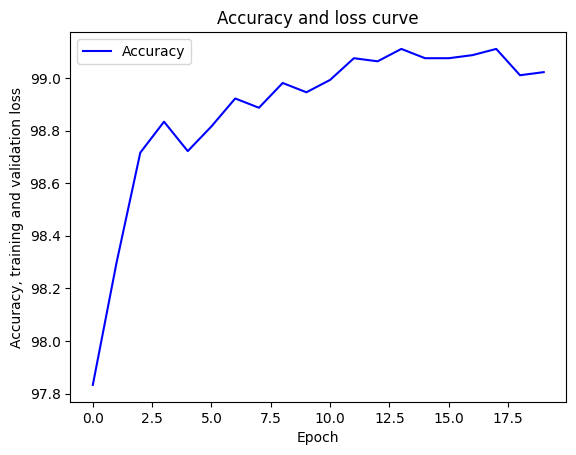

In [27]:
plt.plot(nums, accs, label='Accuracy', color='b')  # Plot first curve in blue

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Accuracy, training and validation loss')
plt.title('Accuracy and loss curve')

# Show the legend
plt.legend()

# Display the plot
plt.show()

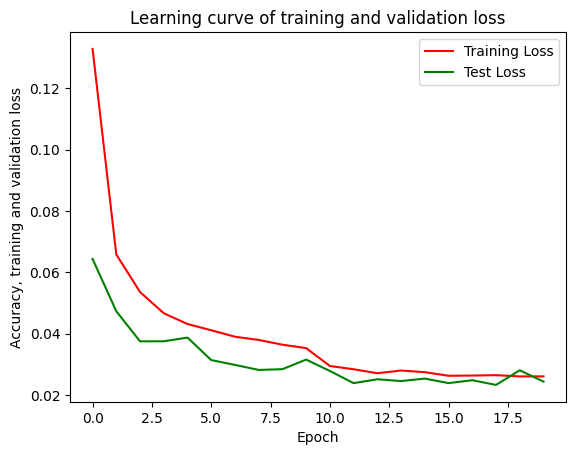

In [28]:
plt.plot(nums, losses, label='Training Loss', color='r')  # Plot second curve in red
plt.plot(nums, test_losses, label='Test Loss', color='g')  # Plot second curve in red

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Accuracy, training and validation loss')
plt.title('Learning curve of training and validation loss')

# Show the legend
plt.legend()

# Display the plot
plt.show()

# Let's see the distribution of weight values

Before we jump into pruning, let's see the distribution of weight values in the dense model.

# Fine-grained Pruning

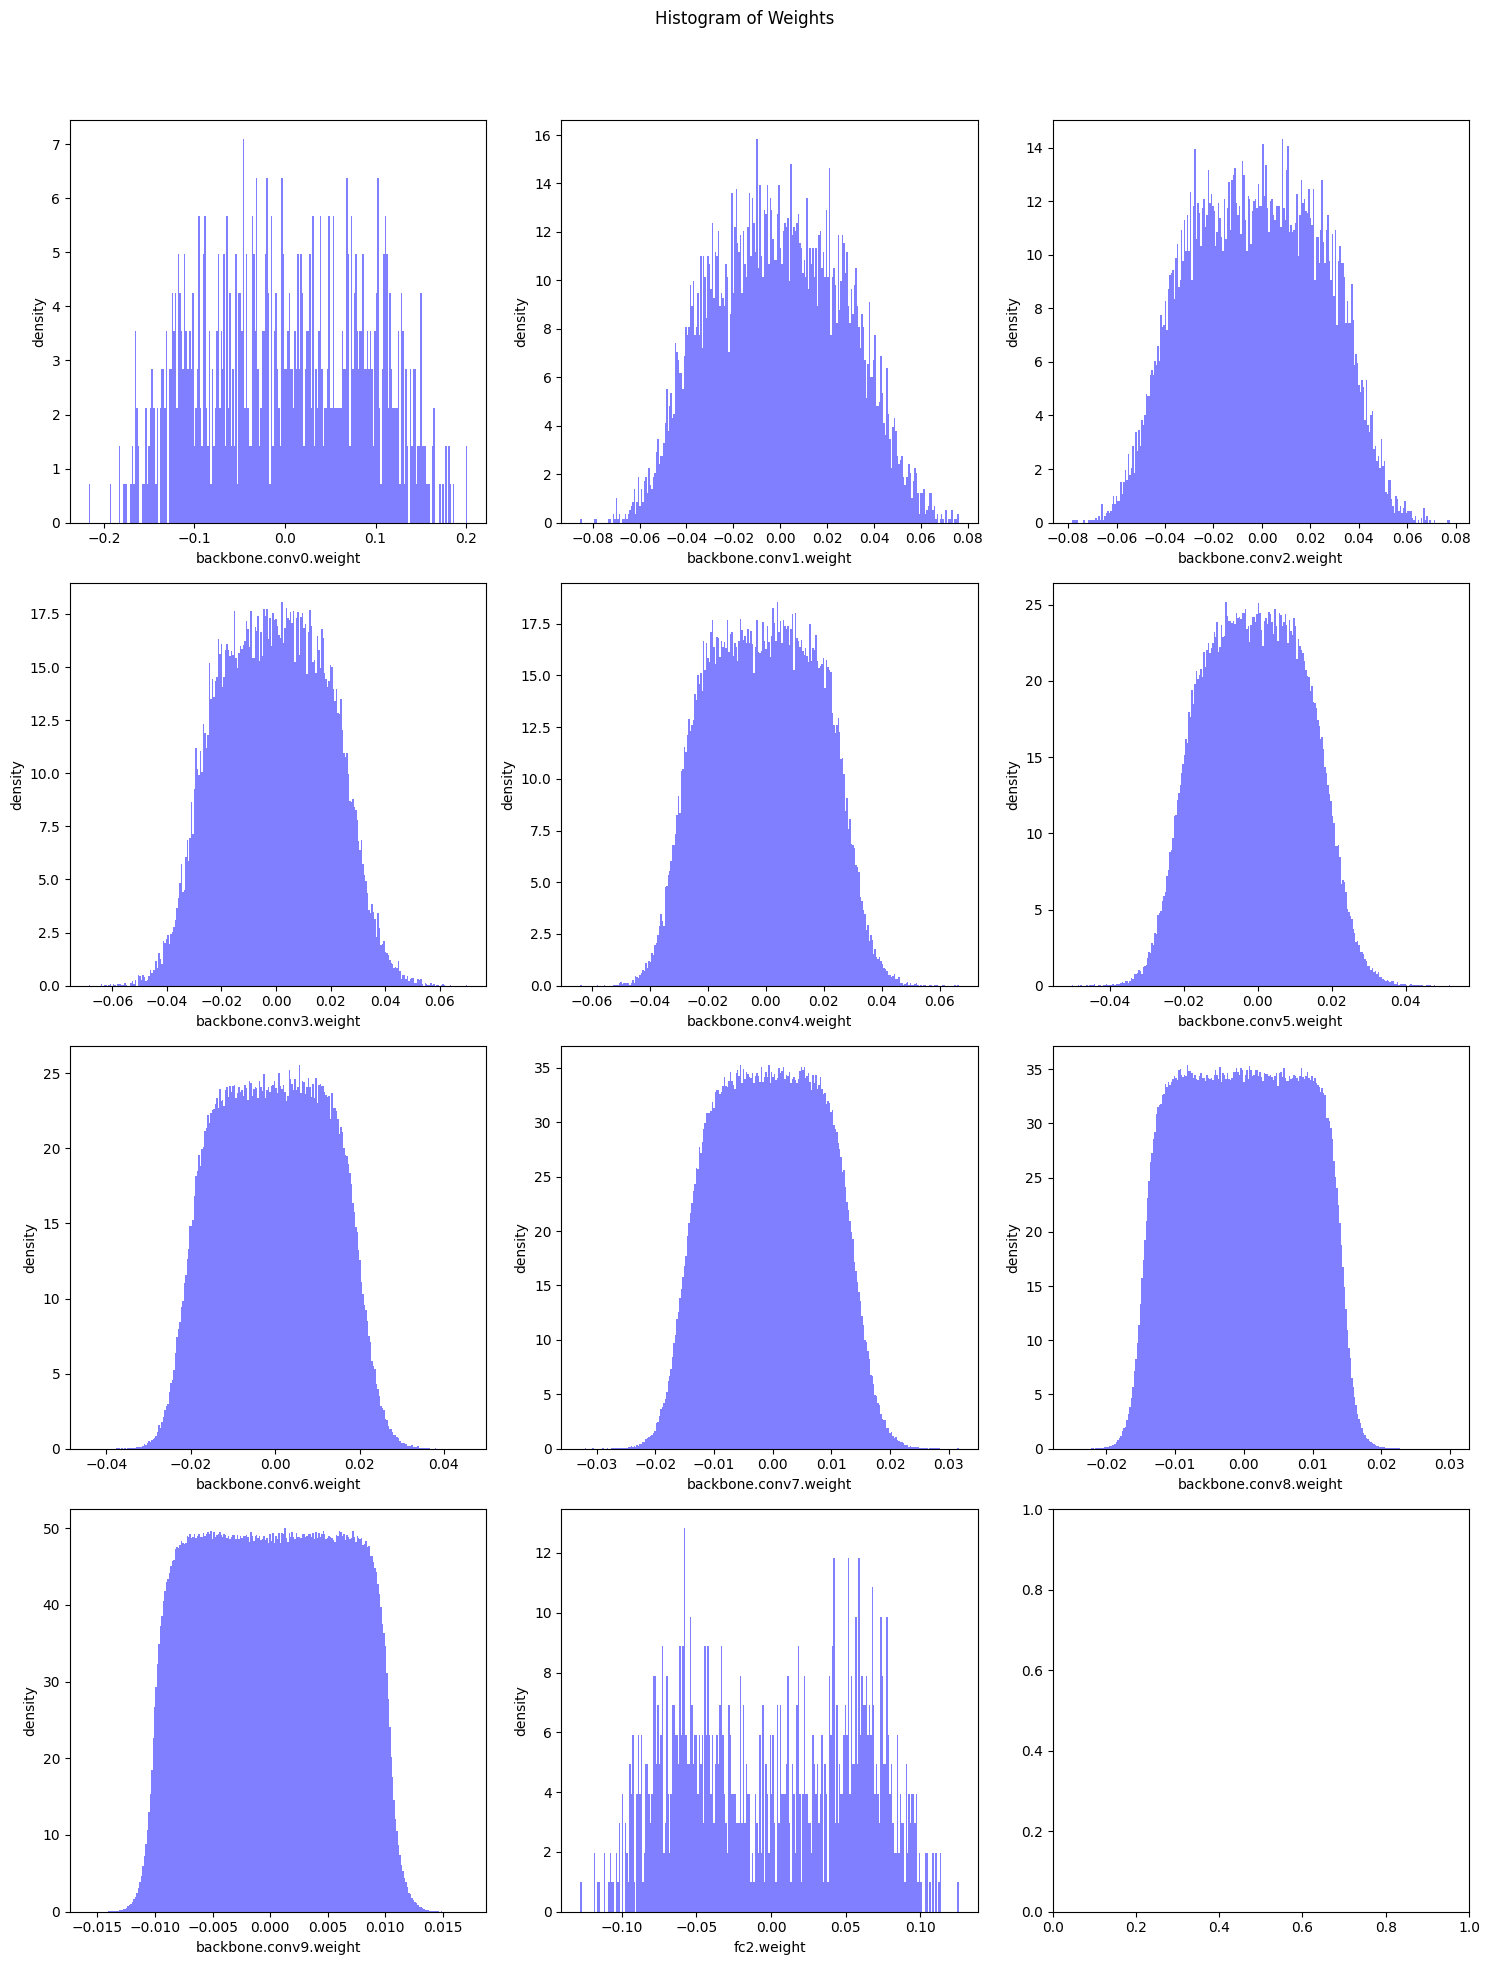

In [29]:
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(4,3, figsize=(15, 20))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_weight_distribution(model)

Define misc functions for verification.

In this section, we will implement and perform fine-grained pruning.

Fine-grained pruning removes the synapses with lowest importance. The weight tensor $W$ will become sparse after fine-grained pruning, which can be described with **sparsity**:

> $\mathrm{sparsity} := \#\mathrm{Zeros} / \#W = 1 - \#\mathrm{Nonzeros} / \#W$

where $\#W$ is the number of elements in $W$.

In practice, given the target sparsity $s$, the weight tensor $W$ is multiplied with a binary mask $M$ to disregard removed weight:

> $v_{\mathrm{thr}} = \texttt{kthvalue}(Importance, \#W \cdot s)$
>
> $M = Importance > v_{\mathrm{thr}}$
>
> $W = W \cdot M$

where $Importance$ is importance tensor with the same shape of $W$, $\texttt{kthvalue}(X, k)$ finds the $k$-th smallest value of tensor $X$, $v_{\mathrm{thr}}$ is the threshold value.

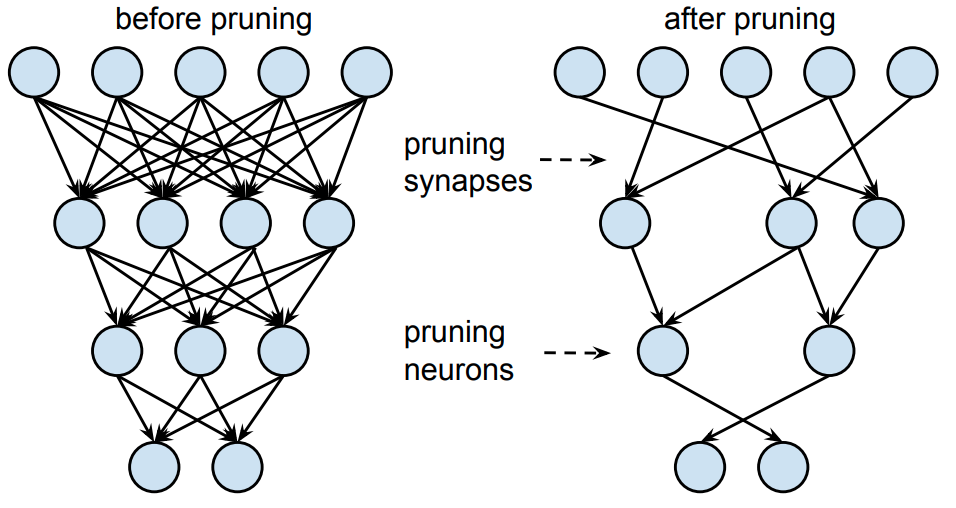

## Magnitude-based Pruning

For fine-grained pruning, a widely-used importance is the magnitude of weight value, *i.e.*,

$Importance=|W|$

This is known as **Magnitude-based Pruning** (see [Learning both Weights and Connections for Efficient
Neural Networks](https://arxiv.org/pdf/1506.02626.pdf)).

In [31]:
sparsity = min(max(0.0, 0.75), 1.0)

In [32]:
def fine_grained_prune(tensor: torch.Tensor, sparsity : float) -> torch.Tensor:
    """
    magnitude-based pruning for single tensor
    :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
    :param sparsity: float, pruning sparsity
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    :return:
        torch.(cuda.)Tensor, mask for zeros
    """
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()

    ##################### YOUR CODE STARTS HERE #####################
    # Step 1: calculate the #zeros (please use round())
    num_zeros = round(num_elements*sparsity)
    print(num_zeros)
    # Step 2: calculate the importance of weight
    importance = torch.abs(tensor)
    print(importance)
    # Step 3: calculate the pruning threshold
    threshold,ind=  torch.kthvalue(torch.abs(tensor.view(-1)), num_zeros)
    print(threshold)
    # Step 4: calculate the pruning mask
    # Step 4: get binary mask (1 for nonzeros, 0 for zeros)
    mask = importance.gt(threshold)
    print(mask)
    ##################### YOUR CODE ENDS HERE #######################

    # Step 5: apply mask to prune the tensor
    tensor.mul_(mask)

    return mask

### Test pruning fuction

In [30]:
def test_fine_grained_prune(
    test_tensor=torch.tensor([[-0.46, -0.40, 0.39, 0.19, 0.37],
                              [0.00, 0.40, 0.17, -0.15, 0.16],
                              [-0.20, -0.23, 0.36, 0.25, 0.03],
                              [0.24, 0.41, 0.07, 0.13, -0.15],
                              [0.48, -0.09, -0.36, 0.12, 0.45]]),
    test_mask=torch.tensor([[True, True, False, False, False],
                            [False, True, False, False, False],
                            [False, False, False, False, False],
                            [False, True, False, False, False],
                            [True, False, False, False, True]]),
    target_sparsity=0.75, target_nonzeros=None):
    def plot_matrix(tensor, ax, title):
        ax.imshow(tensor.cpu().numpy() == 0, vmin=0, vmax=1, cmap='tab20c')
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[1]):
            for j in range(tensor.shape[0]):
                text = ax.text(j, i, f'{tensor[i, j].item():.2f}',
                                ha="center", va="center", color="k")

    test_tensor = test_tensor.clone()
    fig, axes = plt.subplots(1,2, figsize=(6, 10))
    ax_left, ax_right = axes.ravel()
    plot_matrix(test_tensor, ax_left, 'dense tensor')

    sparsity_before_pruning = get_sparsity(test_tensor)
    mask = fine_grained_prune(test_tensor, target_sparsity)
    sparsity_after_pruning = get_sparsity(test_tensor)
    sparsity_of_mask = get_sparsity(mask)

    plot_matrix(test_tensor, ax_right, 'sparse tensor')
    #fig.tight_layout()
    plt.show()

    print('* Test fine_grained_prune()')
    print(f'    target sparsity: {target_sparsity:.2f}')
    print(f'        sparsity before pruning: {sparsity_before_pruning:.2f}')
    print(f'        sparsity after pruning: {sparsity_after_pruning:.2f}')
    print(f'        sparsity of pruning mask: {sparsity_of_mask:.2f}')

    if target_nonzeros is None:
        if test_mask.equal(mask):
            print('* Test passed.')
        else:
            print('* Test failed.')
    else:
        if mask.count_nonzero() == target_nonzeros:
            print('* Test passed.')
        else:
            print('* Test failed.')

The last cell plots the tensor before and after pruning. Nonzeros are rendered in blue while zeros are rendered in gray. Please modify the value of `target_sparsity` in the following code cell so that there are only 10 nonzeros in the sparse tensor after pruning.

19
tensor([[0.4600, 0.4000, 0.3900, 0.1900, 0.3700],
        [0.0000, 0.4000, 0.1700, 0.1500, 0.1600],
        [0.2000, 0.2300, 0.3600, 0.2500, 0.0300],
        [0.2400, 0.4100, 0.0700, 0.1300, 0.1500],
        [0.4800, 0.0900, 0.3600, 0.1200, 0.4500]])
tensor(0.3900)
tensor([[ True,  True, False, False, False],
        [False,  True, False, False, False],
        [False, False, False, False, False],
        [False,  True, False, False, False],
        [ True, False, False, False,  True]])


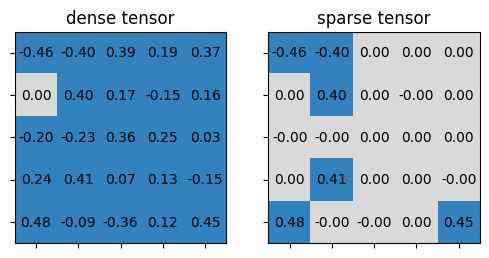

* Test fine_grained_prune()
    target sparsity: 0.75
        sparsity before pruning: 0.04
        sparsity after pruning: 0.76
        sparsity of pruning mask: 0.76
* Test passed.


In [33]:
##################### YOUR CODE STARTS HERE #####################
target_sparsity = .75 # please modify the value of target_sparsity
##################### YOUR CODE ENDS HERE #####################
test_fine_grained_prune(target_sparsity=target_sparsity, target_nonzeros=6)

In [34]:
class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # we only prune conv and fc weights
                masks[name] = fine_grained_prune(param, sparsity_dict[name])
        return masks

## Sensitivity Scan


Different layers contribute differently to the model performance. It is challenging to decide the proper sparsity for each layer. A widely used approach is sensitivity scan.

During the sensitivity scan, at each time, we will only prune one layer to see the accuracy degradation. By scanning different sparsities, we could draw the sensitivity curve (i.e., accuracy vs. sparsity) of the corresponding layer.

Here is an example figure for sensitivity curves. The x-axis is the sparsity or the percentage of #parameters dropped (*i.e.*, sparsity). The y-axis is the validation accuracy. (This is Figure 6 in [Learning both Weights and Connections for Efficient
Neural Networks](https://arxiv.org/pdf/1506.02626.pdf))

The following code cell defines the sensitivity scan function that returns the sparsities scanned, and a list of accuracies for each weight to be pruned.

In [35]:
@torch.no_grad()
def sensitivity_scan(model, dataloader, scan_step=0.1, scan_start=0.4, scan_end=1.0, verbose=True):
    sparsities = np.arange(start=scan_start, stop=scan_end, step=scan_step)
    accuracies = []
    named_conv_weights = [(name, param) for (name, param) \
                          in model.named_parameters() if param.dim() > 1]
    for i_layer, (name, param) in enumerate(named_conv_weights):
        param_clone = param.detach().clone()
        accuracy = []
        for sparsity in tqdm(sparsities, desc=f'scanning {i_layer}/{len(named_conv_weights)} weight - {name}'):
            fine_grained_prune(param.detach(), sparsity=sparsity)
            acc,_ = evaluate(model, dataloader, verbose=False)
            if verbose:
                print(f'\r    sparsity={sparsity:.2f}: accuracy={acc:.2f}%', end='')
            # restore
            param.copy_(param_clone)
            accuracy.append(acc)
        if verbose:
            print(f'\r    sparsity=[{",".join(["{:.2f}".format(x) for x in sparsities])}]: accuracy=[{", ".join(["{:.2f}%".format(x) for x in accuracy])}]', end='')
        accuracies.append(accuracy)
    return sparsities, accuracies

In [36]:
sparsities, accuracies = sensitivity_scan(
    model, dataloader['test'], scan_step=0.1, scan_start=0.1, scan_end=1.0)

scanning 0/11 weight - backbone.conv0.weight:   0%|          | 0/9 [00:00<?, ?it/s]

86
tensor([[[[0.0943, 0.0987, 0.0379],
          [0.0837, 0.1029, 0.1104],
          [0.0540, 0.0031, 0.0725]],

         [[0.0206, 0.1075, 0.0084],
          [0.0245, 0.1050, 0.0423],
          [0.0146, 0.1229, 0.0021]],

         [[0.0348, 0.0662, 0.0953],
          [0.0769, 0.0452, 0.0661],
          [0.1047, 0.1152, 0.0901]]],


        [[[0.0595, 0.1327, 0.0707],
          [0.0980, 0.0739, 0.0759],
          [0.0886, 0.0711, 0.0489]],

         [[0.0153, 0.0670, 0.0353],
          [0.0016, 0.0912, 0.1281],
          [0.0085, 0.0692, 0.1085]],

         [[0.0126, 0.0851, 0.1177],
          [0.0711, 0.0684, 0.0010],
          [0.0534, 0.1337, 0.0539]]],


        [[[0.0007, 0.1128, 0.0939],
          [0.0341, 0.1037, 0.1173],
          [0.0058, 0.0261, 0.0737]],

         [[0.1247, 0.1303, 0.1448],
          [0.0451, 0.1344, 0.1436],
          [0.1025, 0.0202, 0.0395]],

         [[0.0076, 0.0089, 0.1302],
          [0.0482, 0.0801, 0.0456],
          [0.1384, 0.1345, 0.1098]]],


 

scanning 1/11 weight - backbone.conv1.weight:   0%|          | 0/9 [00:00<?, ?it/s]

922
tensor([[[[0.0274, 0.0290, 0.0378],
          [0.0274, 0.0340, 0.0047],
          [0.0005, 0.0212, 0.0045]],

         [[0.0231, 0.0054, 0.0053],
          [0.0169, 0.0028, 0.0488],
          [0.0501, 0.0130, 0.0048]],

         [[0.0243, 0.0354, 0.0134],
          [0.0207, 0.0067, 0.0529],
          [0.0129, 0.0064, 0.0404]],

         ...,

         [[0.0326, 0.0058, 0.0359],
          [0.0431, 0.0234, 0.0002],
          [0.0074, 0.0076, 0.0098]],

         [[0.0361, 0.0454, 0.0034],
          [0.0379, 0.0140, 0.0690],
          [0.0435, 0.0306, 0.0036]],

         [[0.0377, 0.0013, 0.0302],
          [0.0188, 0.0243, 0.0454],
          [0.0191, 0.0321, 0.0297]]],


        [[[0.0377, 0.0379, 0.0033],
          [0.0077, 0.0240, 0.0177],
          [0.0462, 0.0434, 0.0008]],

         [[0.0227, 0.0245, 0.0486],
          [0.0245, 0.0095, 0.0197],
          [0.0468, 0.0249, 0.0167]],

         [[0.0238, 0.0644, 0.0377],
          [0.0113, 0.0372, 0.0049],
          [0.0381, 0.0264, 

scanning 2/11 weight - backbone.conv2.weight:   0%|          | 0/9 [00:00<?, ?it/s]

1843
tensor([[[[0.0098, 0.0019, 0.0317],
          [0.0325, 0.0173, 0.0353],
          [0.0006, 0.0151, 0.0032]],

         [[0.0287, 0.0063, 0.0146],
          [0.0152, 0.0292, 0.0319],
          [0.0037, 0.0351, 0.0095]],

         [[0.0003, 0.0230, 0.0462],
          [0.0058, 0.0035, 0.0140],
          [0.0223, 0.0294, 0.0435]],

         ...,

         [[0.0127, 0.0144, 0.0384],
          [0.0256, 0.0122, 0.0183],
          [0.0414, 0.0008, 0.0069]],

         [[0.0402, 0.0157, 0.0166],
          [0.0016, 0.0031, 0.0280],
          [0.0416, 0.0310, 0.0181]],

         [[0.0286, 0.0360, 0.0127],
          [0.0473, 0.0279, 0.0188],
          [0.0345, 0.0136, 0.0127]]],


        [[[0.0381, 0.0408, 0.0240],
          [0.0452, 0.0334, 0.0210],
          [0.0032, 0.0360, 0.0202]],

         [[0.0140, 0.0319, 0.0072],
          [0.0274, 0.0427, 0.0348],
          [0.0118, 0.0404, 0.0132]],

         [[0.0277, 0.0191, 0.0520],
          [0.0386, 0.0082, 0.0422],
          [0.0249, 0.0310,

scanning 3/11 weight - backbone.conv3.weight:   0%|          | 0/9 [00:00<?, ?it/s]

3686
tensor([[[[1.2522e-02, 1.1168e-02, 2.4356e-02],
          [1.0886e-02, 1.1357e-02, 4.8222e-03],
          [1.3858e-02, 2.9875e-02, 2.3315e-02]],

         [[4.0877e-03, 6.1270e-04, 3.8340e-03],
          [7.4451e-03, 2.9255e-03, 1.4732e-02],
          [3.3795e-03, 1.2663e-02, 3.5187e-02]],

         [[4.7883e-03, 2.6296e-02, 7.0855e-03],
          [1.2849e-04, 8.4835e-03, 2.9942e-02],
          [1.4706e-02, 3.2019e-02, 8.5474e-03]],

         ...,

         [[9.8342e-03, 2.1467e-02, 2.1158e-02],
          [1.5250e-02, 1.7393e-02, 1.9408e-02],
          [1.6811e-02, 2.6054e-02, 2.3947e-02]],

         [[3.0996e-02, 3.2175e-02, 5.7918e-03],
          [2.6298e-02, 1.5058e-02, 1.2538e-02],
          [1.0487e-02, 7.6959e-03, 1.3187e-02]],

         [[2.6414e-02, 3.1526e-03, 2.6925e-02],
          [2.5585e-02, 5.1628e-03, 3.2385e-02],
          [2.4865e-02, 2.1121e-02, 1.5669e-02]]],


        [[[3.5312e-04, 2.2654e-03, 2.2776e-02],
          [1.0612e-02, 1.6654e-02, 1.9019e-02],
      

scanning 4/11 weight - backbone.conv4.weight:   0%|          | 0/9 [00:00<?, ?it/s]

7373
tensor([[[[0.0144, 0.0181, 0.0225],
          [0.0429, 0.0058, 0.0028],
          [0.0232, 0.0146, 0.0290]],

         [[0.0071, 0.0126, 0.0325],
          [0.0153, 0.0031, 0.0322],
          [0.0105, 0.0008, 0.0053]],

         [[0.0095, 0.0057, 0.0062],
          [0.0193, 0.0130, 0.0282],
          [0.0044, 0.0171, 0.0096]],

         ...,

         [[0.0185, 0.0147, 0.0328],
          [0.0163, 0.0196, 0.0042],
          [0.0358, 0.0201, 0.0170]],

         [[0.0102, 0.0160, 0.0146],
          [0.0157, 0.0193, 0.0053],
          [0.0117, 0.0260, 0.0068]],

         [[0.0193, 0.0054, 0.0242],
          [0.0099, 0.0265, 0.0093],
          [0.0290, 0.0272, 0.0329]]],


        [[[0.0062, 0.0222, 0.0293],
          [0.0091, 0.0037, 0.0003],
          [0.0204, 0.0018, 0.0058]],

         [[0.0168, 0.0093, 0.0168],
          [0.0332, 0.0063, 0.0151],
          [0.0387, 0.0278, 0.0150]],

         [[0.0014, 0.0043, 0.0217],
          [0.0030, 0.0091, 0.0104],
          [0.0180, 0.0255,

scanning 5/11 weight - backbone.conv5.weight:   0%|          | 0/9 [00:00<?, ?it/s]

14746
tensor([[[[7.4189e-03, 5.0617e-04, 2.0368e-02],
          [5.7406e-03, 1.1810e-02, 5.2687e-03],
          [1.0027e-02, 1.5101e-02, 1.0953e-02]],

         [[1.3329e-02, 1.9498e-02, 2.3648e-02],
          [3.3652e-03, 1.0904e-02, 9.8999e-03],
          [1.1515e-02, 1.2876e-02, 1.5344e-02]],

         [[4.6073e-03, 6.4534e-03, 2.2626e-05],
          [7.8211e-03, 1.4967e-02, 1.2245e-02],
          [5.4427e-03, 7.6691e-03, 1.0756e-03]],

         ...,

         [[2.1404e-02, 1.8034e-02, 7.7374e-03],
          [6.2406e-03, 6.2046e-03, 8.4134e-03],
          [9.4087e-03, 1.5129e-02, 1.2504e-02]],

         [[2.0327e-02, 2.7197e-03, 1.5553e-02],
          [1.6997e-02, 1.9501e-03, 8.9700e-03],
          [1.3777e-02, 6.2237e-03, 2.0933e-02]],

         [[8.2295e-03, 2.7291e-03, 7.4954e-03],
          [2.4117e-03, 5.3904e-03, 9.7678e-03],
          [1.6420e-02, 2.1400e-02, 1.2210e-02]]],


        [[[2.2438e-02, 1.0967e-02, 2.4104e-02],
          [6.1421e-03, 2.6576e-04, 4.1690e-03],
     

scanning 6/11 weight - backbone.conv6.weight:   0%|          | 0/9 [00:00<?, ?it/s]

29491
tensor([[[[2.0301e-02, 1.3684e-02, 7.1921e-03],
          [1.1723e-02, 2.3856e-02, 1.8524e-02],
          [1.0349e-02, 2.4176e-02, 4.9140e-03]],

         [[4.0525e-03, 1.2802e-02, 2.2120e-02],
          [1.3093e-02, 8.0737e-03, 1.5688e-02],
          [1.0849e-02, 1.3316e-02, 1.0555e-03]],

         [[1.2077e-02, 1.4240e-02, 5.1170e-03],
          [1.3189e-02, 1.8886e-02, 8.8581e-03],
          [1.4162e-02, 5.7363e-03, 1.3614e-02]],

         ...,

         [[1.1290e-02, 8.9109e-03, 9.9791e-03],
          [1.4943e-02, 8.1613e-03, 4.1873e-03],
          [5.7161e-03, 1.5566e-02, 6.4451e-03]],

         [[1.2316e-02, 4.5105e-03, 1.6871e-02],
          [1.8742e-03, 1.9284e-02, 4.7239e-03],
          [1.4711e-02, 4.5534e-03, 7.0845e-03]],

         [[9.0261e-04, 1.9394e-02, 1.2098e-02],
          [1.2983e-02, 1.7158e-02, 4.8056e-03],
          [1.3758e-02, 1.0683e-02, 9.3404e-03]]],


        [[[3.3336e-03, 1.3439e-02, 1.8652e-02],
          [4.4569e-03, 7.4696e-03, 1.6207e-02],
     

scanning 7/11 weight - backbone.conv7.weight:   0%|          | 0/9 [00:00<?, ?it/s]

58982
tensor([[[[0.0118, 0.0195, 0.0059],
          [0.0093, 0.0142, 0.0018],
          [0.0027, 0.0109, 0.0094]],

         [[0.0108, 0.0078, 0.0085],
          [0.0100, 0.0010, 0.0016],
          [0.0049, 0.0144, 0.0062]],

         [[0.0057, 0.0109, 0.0060],
          [0.0061, 0.0037, 0.0076],
          [0.0079, 0.0046, 0.0031]],

         ...,

         [[0.0065, 0.0090, 0.0138],
          [0.0143, 0.0036, 0.0107],
          [0.0034, 0.0154, 0.0014]],

         [[0.0073, 0.0078, 0.0058],
          [0.0034, 0.0008, 0.0077],
          [0.0131, 0.0121, 0.0100]],

         [[0.0071, 0.0118, 0.0062],
          [0.0075, 0.0090, 0.0033],
          [0.0028, 0.0002, 0.0123]]],


        [[[0.0025, 0.0127, 0.0129],
          [0.0126, 0.0087, 0.0076],
          [0.0136, 0.0139, 0.0099]],

         [[0.0155, 0.0024, 0.0029],
          [0.0159, 0.0029, 0.0134],
          [0.0150, 0.0025, 0.0030]],

         [[0.0001, 0.0135, 0.0017],
          [0.0083, 0.0122, 0.0098],
          [0.0131, 0.0068

scanning 8/11 weight - backbone.conv8.weight:   0%|          | 0/9 [00:00<?, ?it/s]

117965
tensor([[[[2.0940e-03, 1.2375e-02, 1.1408e-02],
          [9.7261e-03, 1.4441e-02, 1.0308e-03],
          [3.1320e-03, 2.0059e-03, 5.9759e-03]],

         [[4.1652e-03, 1.0484e-02, 5.5969e-03],
          [1.2520e-02, 9.0103e-03, 5.2743e-03],
          [2.2989e-03, 1.0037e-02, 1.2103e-02]],

         [[2.4415e-05, 1.1906e-03, 3.1342e-03],
          [1.0780e-02, 4.2463e-03, 6.3318e-03],
          [4.3998e-03, 1.1025e-02, 1.2822e-02]],

         ...,

         [[2.6440e-03, 6.7965e-03, 3.4450e-03],
          [9.5214e-03, 2.3446e-03, 4.4425e-03],
          [1.1268e-02, 1.2252e-02, 1.4924e-02]],

         [[1.0049e-02, 3.2745e-03, 1.8680e-03],
          [1.5022e-02, 3.0926e-03, 3.6674e-03],
          [1.7324e-03, 4.3411e-03, 8.4132e-03]],

         [[3.0459e-03, 7.9737e-04, 7.8172e-03],
          [2.1328e-03, 1.2864e-03, 7.8136e-03],
          [9.6685e-03, 7.3787e-03, 3.4914e-03]]],


        [[[3.5050e-03, 6.8259e-04, 5.3905e-03],
          [3.7397e-03, 3.5309e-03, 2.3879e-03],
    

scanning 9/11 weight - backbone.conv9.weight:   0%|          | 0/9 [00:00<?, ?it/s]

235930
tensor([[[[0.0085, 0.0061, 0.0014],
          [0.0018, 0.0076, 0.0082],
          [0.0097, 0.0093, 0.0099]],

         [[0.0087, 0.0048, 0.0036],
          [0.0049, 0.0060, 0.0044],
          [0.0037, 0.0012, 0.0032]],

         [[0.0097, 0.0052, 0.0081],
          [0.0095, 0.0101, 0.0093],
          [0.0066, 0.0084, 0.0055]],

         ...,

         [[0.0064, 0.0054, 0.0017],
          [0.0049, 0.0039, 0.0055],
          [0.0019, 0.0087, 0.0083]],

         [[0.0088, 0.0093, 0.0077],
          [0.0089, 0.0012, 0.0022],
          [0.0017, 0.0045, 0.0034]],

         [[0.0093, 0.0002, 0.0005],
          [0.0022, 0.0002, 0.0067],
          [0.0099, 0.0067, 0.0070]]],


        [[[0.0015, 0.0016, 0.0020],
          [0.0091, 0.0095, 0.0041],
          [0.0033, 0.0094, 0.0078]],

         [[0.0094, 0.0099, 0.0098],
          [0.0086, 0.0077, 0.0094],
          [0.0069, 0.0066, 0.0008]],

         [[0.0055, 0.0062, 0.0018],
          [0.0104, 0.0061, 0.0033],
          [0.0102, 0.006

scanning 10/11 weight - fc2.weight:   0%|          | 0/9 [00:00<?, ?it/s]

102
tensor([[0.0291, 0.0024, 0.0115,  ..., 0.0791, 0.0330, 0.0226],
        [0.0211, 0.0305, 0.0072,  ..., 0.0545, 0.0756, 0.0671]],
       device='cuda:0')
tensor(0.0122, device='cuda:0')
tensor([[ True, False, False,  ...,  True,  True,  True],
        [ True,  True, False,  ...,  True,  True,  True]], device='cuda:0')
    sparsity=0.10: accuracy=99.10%205
tensor([[0.0291, 0.0024, 0.0115,  ..., 0.0791, 0.0330, 0.0226],
        [0.0211, 0.0305, 0.0072,  ..., 0.0545, 0.0756, 0.0671]],
       device='cuda:0')
tensor(0.0247, device='cuda:0')
tensor([[ True, False, False,  ...,  True,  True, False],
        [False,  True, False,  ...,  True,  True,  True]], device='cuda:0')
    sparsity=0.20: accuracy=99.10%307
tensor([[0.0291, 0.0024, 0.0115,  ..., 0.0791, 0.0330, 0.0226],
        [0.0211, 0.0305, 0.0072,  ..., 0.0545, 0.0756, 0.0671]],
       device='cuda:0')
tensor(0.0360, device='cuda:0')
tensor([[False, False, False,  ...,  True, False, False],
        [False, False, False,  ...,  Tr

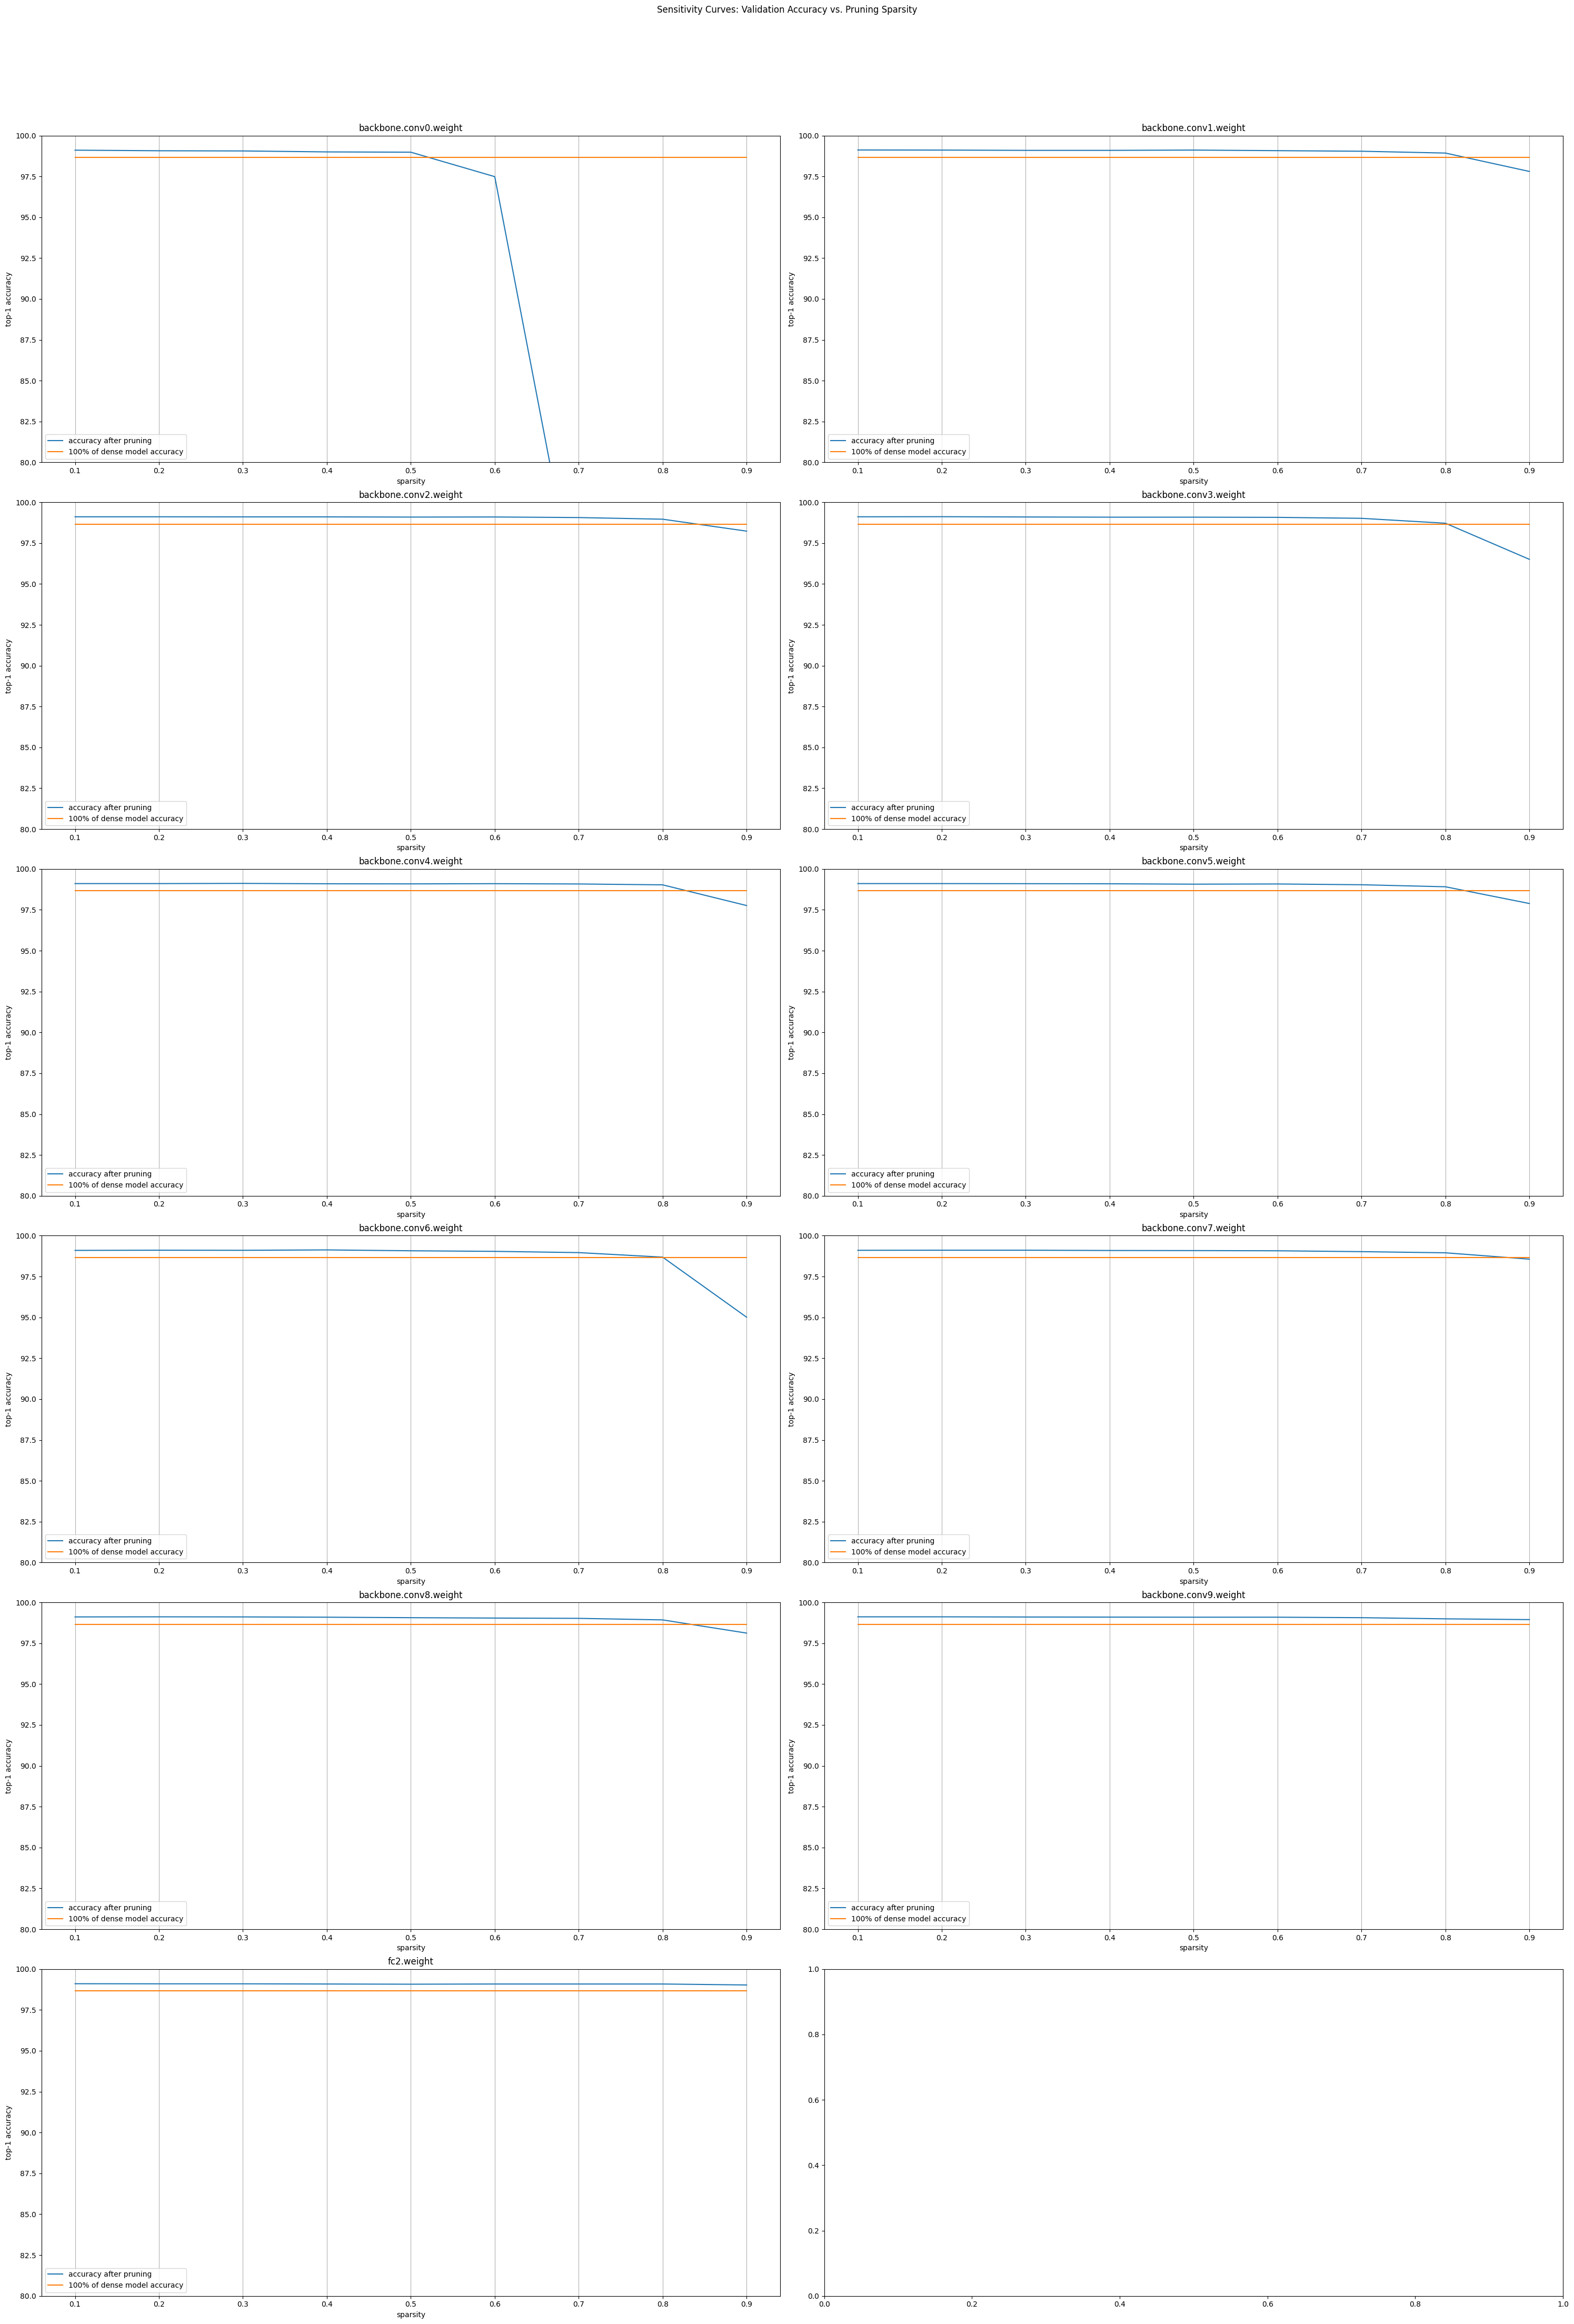

In [37]:
def plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy):
    lower_bound_accuracy = 100 - (100 - dense_model_accuracy) * 1.5
    fig, axes = plt.subplots(6, 2,figsize=(30,45))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            curve = ax.plot(sparsities, accuracies[plot_index])
            line = ax.plot(sparsities, [lower_bound_accuracy] * len(sparsities))
            ax.set_xticks(np.arange(start=0.1, stop=1.0, step=0.1))
            ax.set_ylim(80, 100)
            ax.set_title(name)
            ax.set_xlabel('sparsity')
            ax.set_ylabel('top-1 accuracy')
            ax.legend([
                'accuracy after pruning',
                f'{lower_bound_accuracy / dense_model_accuracy * 100:.0f}% of dense model accuracy'
            ])
            ax.grid(axis='x')
            plot_index += 1
    fig.suptitle('Sensitivity Curves: Validation Accuracy vs. Pruning Sparsity')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy)

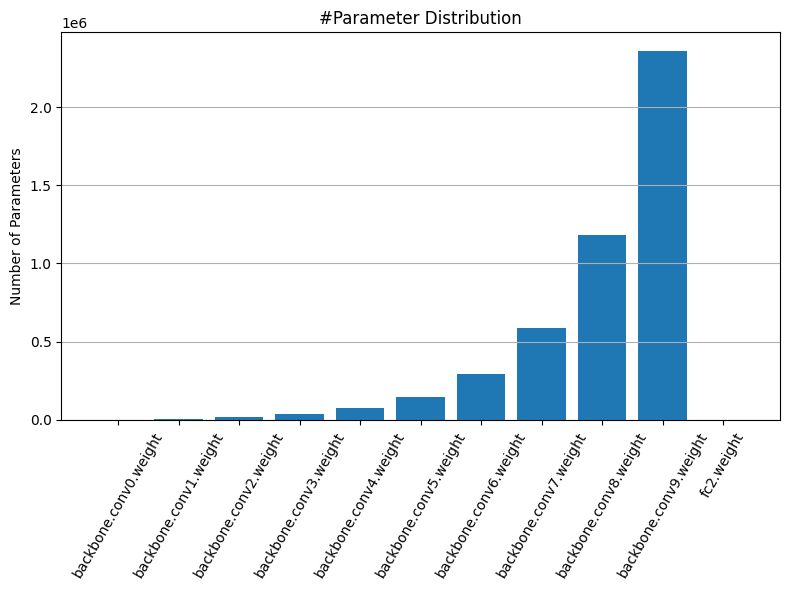

In [38]:
def plot_num_parameters_distribution(model):
    num_parameters = dict()
    for name, param in model.named_parameters():
        if param.dim() > 1:
            num_parameters[name] = param.numel()
    fig = plt.figure(figsize=(8, 6))
    plt.grid(axis='y')
    plt.bar(list(num_parameters.keys()), list(num_parameters.values()))
    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

plot_num_parameters_distribution(model)

## Select Sparsity Based on Sensitivity Curves and \#Parameters Distribution





Based on the sensitivity curves and the distribution of #parameters in the model, please select the sparsity for each layer.

Note that the overall compression ratio of pruned model mostly depends on the layers with larger #parameters, and different layers have different sensitivity to pruning (see Question 4).

Please make sure that after pruning, the sparse model is 25% of the size of the dense model, and validation accuracy is higher than 92.5 after finetuning.
:
*   The layer with more #parameters should have larger sparsity. (see *Figure #Parameter Distribution*)
*   The layer that is sensitive to the pruning sparsity (i.e., the accuracy will drop quickly as sparsity becomes higher) should have smaller sparsity. (see *Figure Sensitivity Curves*)

In [39]:
i=0
for name, parameter in model.named_parameters():
    if parameter.dim() > 1:
        print(f"'{name}': 0.,")
        i+=1

'backbone.conv0.weight': 0.,
'backbone.conv1.weight': 0.,
'backbone.conv2.weight': 0.,
'backbone.conv3.weight': 0.,
'backbone.conv4.weight': 0.,
'backbone.conv5.weight': 0.,
'backbone.conv6.weight': 0.,
'backbone.conv7.weight': 0.,
'backbone.conv8.weight': 0.,
'backbone.conv9.weight': 0.,
'fc2.weight': 0.,


In [40]:
recover_model()

sparsity_dict = {
##################### YOUR CODE STARTS HERE #####################
    # please modify the sparsity value of each layer
    # please DO NOT modify the key of sparsity_dict
'backbone.conv0.weight': 0.5,
'backbone.conv1.weight': 0.85,
'backbone.conv2.weight': 0.85,
'backbone.conv3.weight': 0.9,
'backbone.conv4.weight': 0.9,
'backbone.conv5.weight': 0.9,
'backbone.conv6.weight': 0.9,
'backbone.conv7.weight': 0.95,
'backbone.conv8.weight': 0.95,
'backbone.conv9.weight': 0.95,
'fc2.weight': 0.95,
      ##################### YOUR CODE ENDS HERE #######################
}

Please run the following cell to prune the model according to your defined `sparsity_dict`, and print the information of sparse model.

In [41]:
pruned_model=copy.deepcopy(model)

In [ ]:
pruner = FineGrainedPruner(pruned_model, sparsity_dict)
print(f'After pruning with sparsity dictionary')
for name, sparsity in sparsity_dict.items():
    print(f'  {name}: {sparsity:.2f}')
print(f'The sparsity of each layer becomes')
for name, param in pruned_model.named_parameters():
    if name in sparsity_dict:
        print(f'  {name}: {get_sparsity(param):.2f}')

sparse_model_size = get_model_size(pruned_model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy,_ = evaluate(pruned_model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% before fintuning")



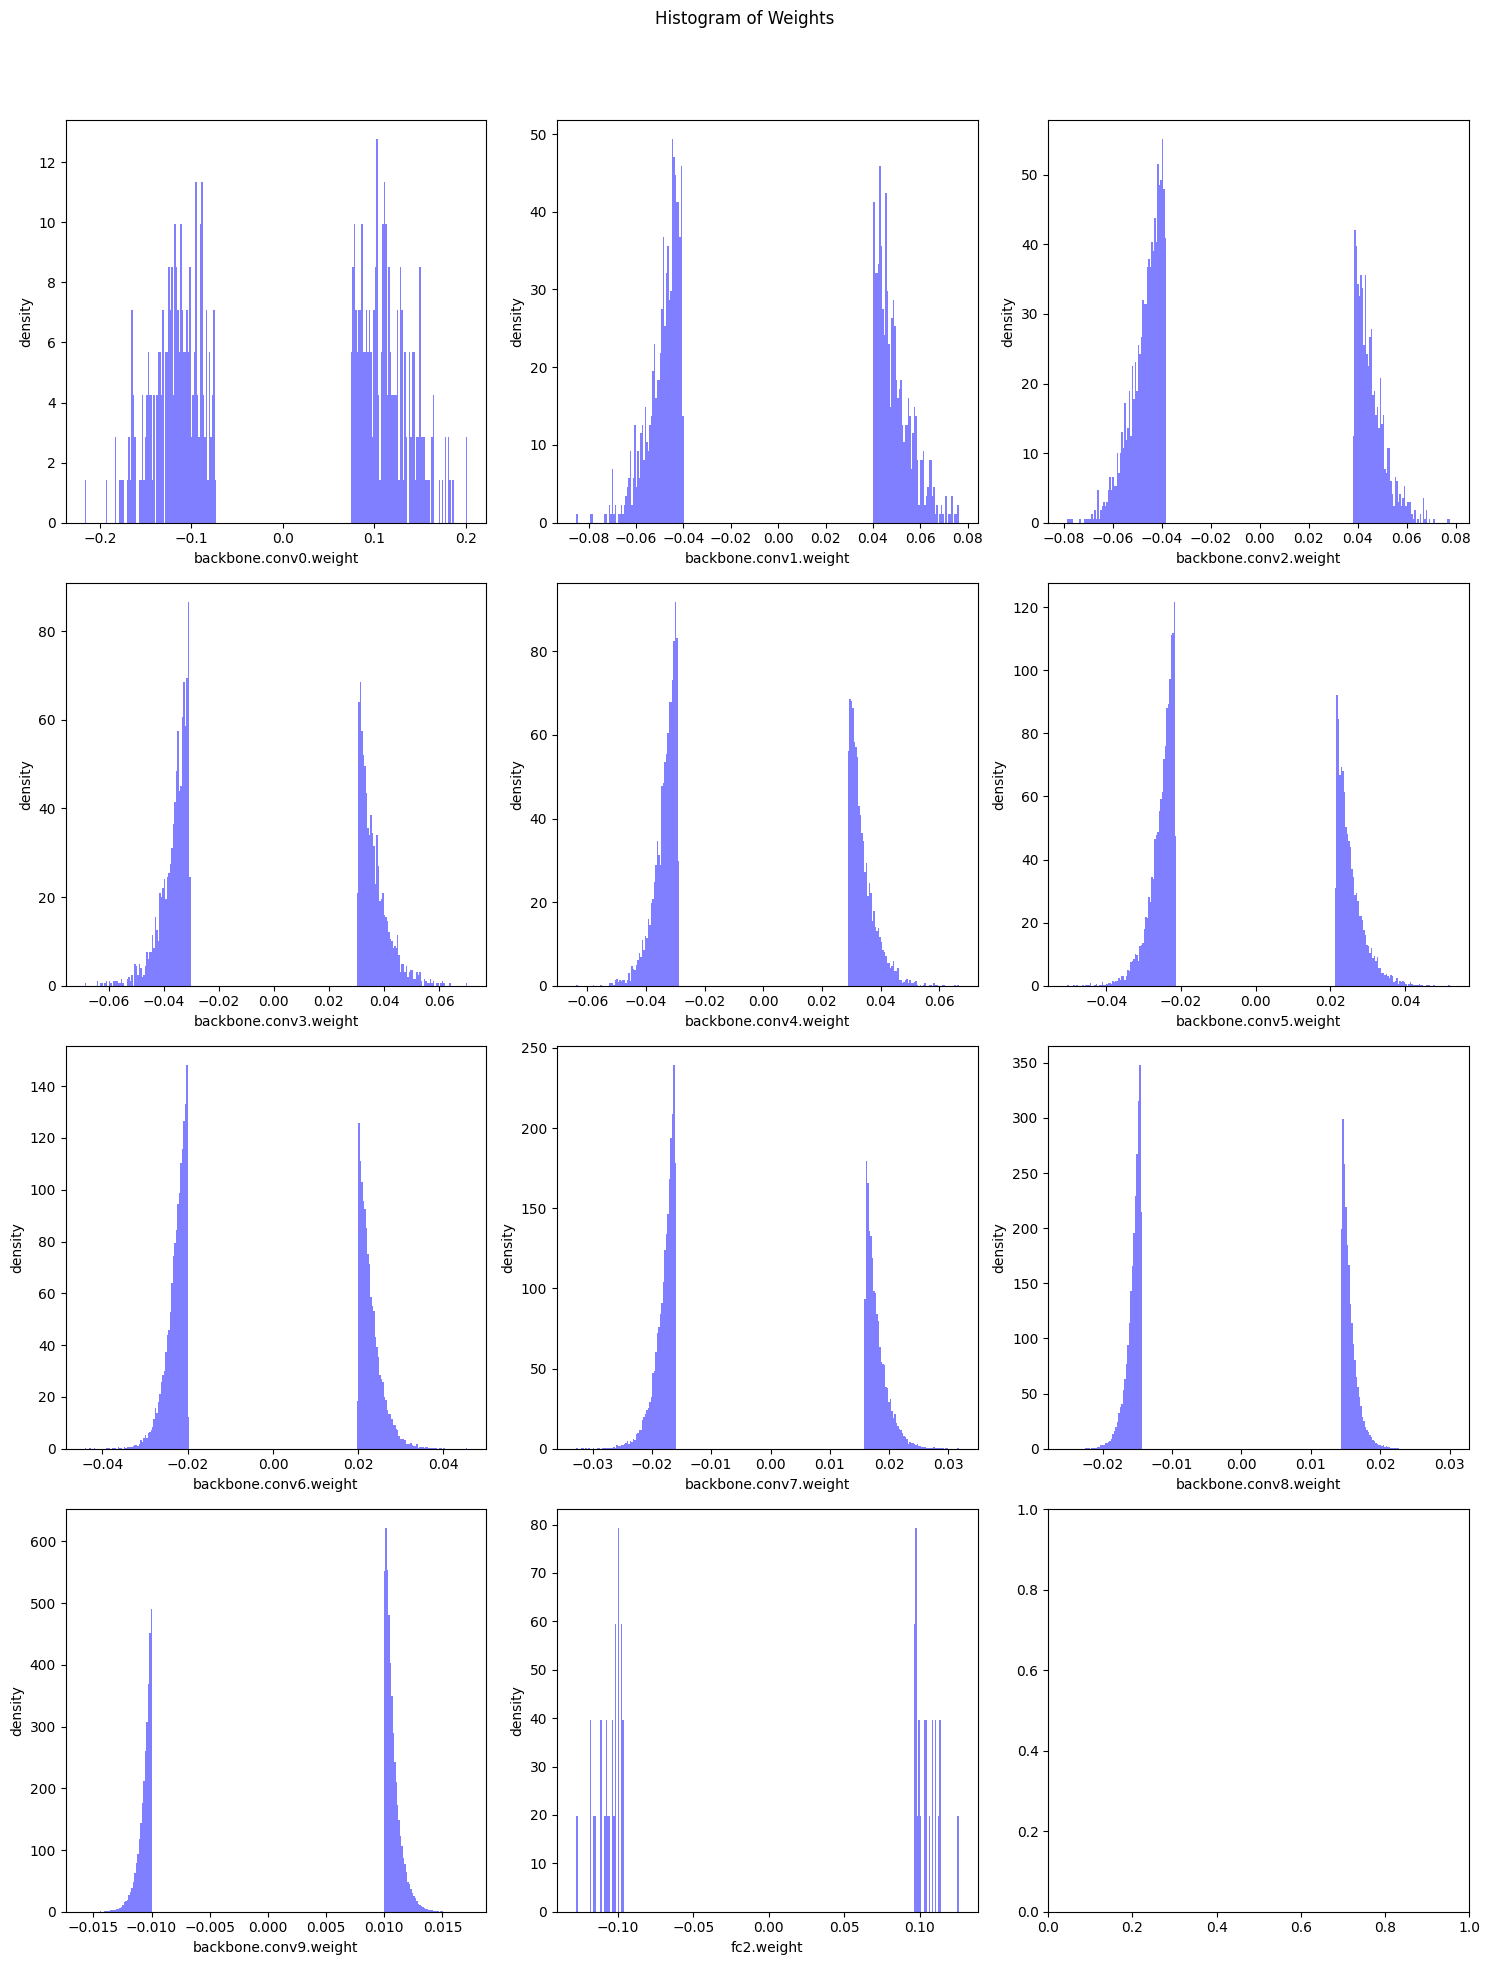

In [43]:
plot_weight_distribution(pruned_model, count_nonzero_only=True)

## Finetune the fine-grained pruned model

As we can see from the outputs of previous cell, even though fine-grained pruning reduces the most of model weights, the accuracy of model also dropped. Therefore, we have to finetune the sparse model to recover the accuracy.

Please run the following cell to finetune the sparse model. It should take around 3 minutes to finish.

In [29]:
num_finetune_epochs = 5
optimizer = torch.optim.SGD(pruned_model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_sparse_model_checkpoint = dict()
best_accuracy = 0
print(f'Finetuning Fine-grained Pruned Sparse Model')
for epoch in range(num_finetune_epochs):
    # At the end of each train iteration, we have to apply the pruning mask
    #    to keep the model sparse during the training
    train_loss=train(pruned_model, dataloader['train'], criterion, optimizer, scheduler,
          callbacks=[lambda: pruner.apply(pruned_model)])
    accuracy ,test_loss = evaluate(pruned_model, dataloader['test'],criterion)
    is_best = test_acc > best_accuracy
    if is_best:
        best_sparse_model_checkpoint['state_dict'] = copy.deepcopy(pruned_model.state_dict())
        best_accuracy = test_acc
    print(f'    Epoch {epoch+1} Test accuracy:{accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%, train loss: {train_loss:.4f}, test loss {test_loss:.4f}')

NameError: name 'pruned_model' is not defined

Run the following cell to see the information of best finetuned sparse model.

In [45]:
all_labels, all_preds,all_outputs,loss = get_labels_preds(pruned_model, dataloader["test"])
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
conf_matrix=confusion_matrix(all_labels, all_preds)
print(conf_matrix)

Precision: 0.9902, Recall: 0.9900, F1: 0.9901
[[8219  128]
 [  40 8593]]


In [46]:
# load the best sparse model checkpoint to evaluate the final performance
pruned_model.load_state_dict(best_sparse_model_checkpoint['state_dict'])
sparse_model_size = get_model_size(pruned_model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy,_ = evaluate(pruned_model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% after fintuning")

Sparse model has size=1.03 MiB = 5.73% of dense model size


eval:   0%|          | 0/531 [00:00<?, ?it/s]

Sparse model has accuracy=98.95% after fintuning


Save the pruned model

In [ ]:
PATH="./vgg.cifar.fg_pruned.pth"
torch.save(model.state_dict(), PATH)

Latency Mac and parameters comparison in CPU

In [47]:
# helper functions to measure latency of a regular PyTorch models.
#   Unlike fine-grained pruning, channel pruning
#   can directly leads to model size reduction and speed up.
@torch.no_grad()
def measure_latency(model, dummy_input, n_warmup=20, n_test=100):
    model.eval()
    # warmup
    for _ in range(n_warmup):
        _ = model(dummy_input)
    # real test
    t1 = time.time()
    for _ in range(n_test):
        _ = model(dummy_input)
    t2 = time.time()
    return (t2 - t1) / n_test  # average latency

table_template = "{:<15} {:<15} {:<15} {:<15}"
print (table_template.format('', 'Original','Pruned','Reduction Ratio'))

# 1. measure the latency of the original model and the pruned model on CPU
#   which simulates inference on an edge device
dummy_input = torch.randn(1, 3, 224, 224).to('cpu')
pruned_model = pruned_model.to('cpu')
model = model.to('cpu')

pruned_latency = measure_latency(pruned_model, dummy_input)
original_latency = measure_latency(model, dummy_input)
print(table_template.format('Latency (ms)',
                            round(original_latency * 1000, 1),
                            round(pruned_latency * 1000, 1),
                            round(original_latency / pruned_latency, 1)))

# 2. measure the computation (MACs)
original_macs = get_model_macs(model, dummy_input)
pruned_macs = get_model_macs(pruned_model, dummy_input)
print(table_template.format('MACs (M)',
                            round(original_macs / 1e6),
                            round(pruned_macs / 1e6),
                            round(original_macs / pruned_macs, 1)))

# 3. measure the model size (params)
original_param = get_num_parameters(model,count_nonzero_only=True)
pruned_param = get_num_parameters(pruned_model,count_nonzero_only=True)
print(table_template.format('Param (M)',
                            round(int(original_param) / 1e6, 2),
                            round(int(pruned_param) / 1e6, 2),
                            round(int(original_param) / int(pruned_param), 1)))

# put model back to cuda
pruned_model = pruned_model.to('cuda')
model = model.to('cuda')

                Original        Pruned          Reduction Ratio
Latency (ms)    41.5            41.7            1.0            
MACs (M)        3287            3287            1.0            
Param (M)       4.72            0.27            17.4           


Latency Mac and parameters comparison in GPU

In [48]:
# helper functions to measure latency of a regular PyTorch models.
#   Unlike fine-grained pruning, channel pruning
#   can directly leads to model size reduction and speed up.
@torch.no_grad()
def measure_latency(model, dummy_input, n_warmup=20, n_test=100):
    model.eval()
    # warmup
    for _ in range(n_warmup):
        _ = model(dummy_input)
    # real test
    t1 = time.time()
    for _ in range(n_test):
        _ = model(dummy_input)
    t2 = time.time()
    return (t2 - t1) / n_test  # average latency

table_template = "{:<15} {:<15} {:<15} {:<15}"
print (table_template.format('', 'Original','Pruned','Reduction Ratio'))

# 1. measure the latency of the original model and the pruned model on CPU
#   which simulates inference on an edge device
dummy_input = torch.randn(1, 3, 224, 224).to('cuda')


pruned_latency = measure_latency(pruned_model, dummy_input)
original_latency = measure_latency(model, dummy_input)
print(table_template.format('Latency (ms)',
                            round(original_latency * 1000, 1),
                            round(pruned_latency * 1000, 1),
                            round(original_latency / pruned_latency, 1)))

# 2. measure the computation (MACs)
original_macs = get_model_macs(model, dummy_input)
pruned_macs = get_model_macs(pruned_model, dummy_input)
print(table_template.format('MACs (M)',
                            round(original_macs / 1e6),
                            round(pruned_macs / 1e6),
                            round(original_macs / pruned_macs, 1)))

# 3. measure the model size (params)
original_param = get_num_parameters(model,count_nonzero_only=True)
pruned_param = get_num_parameters(pruned_model,count_nonzero_only=True)
print(table_template.format('Param (M)',
                            round(int(original_param) / 1e6, 2),
                            round(int(pruned_param) / 1e6, 2),
                            round(int(original_param) / int(pruned_param), 1)))


                Original        Pruned          Reduction Ratio
Latency (ms)    1.6             2.0             0.8            
MACs (M)        3287            3287            1.0            
Param (M)       4.72            0.27            17.4           


# Channel Pruning

In this section, we will implement the channel pruning. Channel pruning removes an entire channel, so that it can achieve inference speed up on existing hardware like GPUs. Similarly, we remove the channels whose weights are of smaller magnitudes (measured by Frobenius norm).

In [49]:
# firstly, let's restore the model weights to the original dense version
#   and check the validation accuracy
recover_model()
dense_model_accuracy,_ = evaluate(model, dataloader['test'])
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")

eval:   0%|          | 0/531 [00:00<?, ?it/s]

dense model has accuracy=99.11%


## Remove Channel Weights

Unlike fine-grained pruning, we can remove the weights entirely from the tensor in channel pruning. That is to say, the number of output channels is reduced:

> $\#\mathrm{out\_channels}_{\mathrm{new}} = \#\mathrm{out\_channels}_{\mathrm{origin}} \cdot (1 - \mathrm{sparsity})$

The weight tensor $W$ is still dense after channel pruning. Thus, we will refer to *sparsity* as ***prune ratio***.

Like fine-grained pruning, we can use different pruning rates for different layers. However, we use a uniform pruning rate for all the layers for now. We are targeting 2x computation reduction, which is roughly 30% uniform pruning rate (think about why).

Feel free to try out different pruning ratios per layer at the end of this section. You can pass in a list of ratios to the `channel_prune` function.


Here we naively prune all output channels other than the first $\#\mathrm{out\_channels}_{\mathrm{new}}$ channels.

In [50]:
def get_num_channels_to_keep(channels: int, prune_ratio: float) -> int:
    """A function to calculate the number of layers to PRESERVE after pruning
    Note that preserve_rate = 1. - prune_ratio
    """
    ##################### YOUR CODE STARTS HERE #####################
    return round(channels*(1-prune_ratio))
    ##################### YOUR CODE ENDS HERE #####################

@torch.no_grad()
def channel_prune(model: nn.Module,
                  prune_ratio: Union[List, float]) -> nn.Module:
    """Apply channel pruning to each of the conv layer in the backbone
    Note that for prune_ratio, we can either provide a floating-point number,
    indicating that we use a uniform pruning rate for all layers, or a list of
    numbers to indicate per-layer pruning rate.
    """
    # sanity check of provided prune_ratio
    assert isinstance(prune_ratio, (float, list))
    n_conv = len([m for m in model.backbone if isinstance(m, nn.Conv2d)])
    # note that for the ratios, it affects the previous conv output and next
    # conv input, i.e., conv0 - ratio0 - conv1 - ratio1-...
    if isinstance(prune_ratio, list):
        assert len(prune_ratio) == n_conv - 1
    else:  # convert float to list
        prune_ratio = [prune_ratio] * (n_conv - 1)

    # we prune the convs in the backbone with a uniform ratio
    model = copy.deepcopy(model)  # prevent overwrite
    # we only apply pruning to the backbone features
    all_convs = [m for m in model.backbone if isinstance(m, nn.Conv2d)]
    all_bns = [m for m in model.backbone if isinstance(m, nn.BatchNorm2d)]
    # apply pruning. we naively keep the first k channels
    assert len(all_convs) == len(all_bns)
    for i_ratio, p_ratio in enumerate(prune_ratio):
        prev_conv = all_convs[i_ratio]
        prev_bn = all_bns[i_ratio]
        next_conv = all_convs[i_ratio + 1]
        original_channels = prev_conv.out_channels  # same as next_conv.in_channels
        n_keep = get_num_channels_to_keep(original_channels, p_ratio)

        # prune the output of the previous conv and bn
        prev_conv.weight.set_(prev_conv.weight.detach()[:n_keep])
        prev_bn.weight.set_(prev_bn.weight.detach()[:n_keep])
        prev_bn.bias.set_(prev_bn.bias.detach()[:n_keep])
        prev_bn.running_mean.set_(prev_bn.running_mean.detach()[:n_keep])
        prev_bn.running_var.set_(prev_bn.running_var.detach()[:n_keep])

        # prune the input of the next conv (hint: just one line of code)
        ##################### YOUR CODE STARTS HERE #####################
        next_conv.weight.set_(next_conv.weight.detach()[:,:n_keep])
 #       next_conv.in_channels=n_keep
 #       prev_conv.out_channels=n_keep
        ##################### YOUR CODE ENDS HERE #####################

    return model


## Ranking Channels by Importance

As you can see, removing the first 30% of channels in all layers leads to significant accuracy reduction. One potential method to remedy the issue is to find the **less important** channel weights to remove. A popular criterion for importance is to use the Frobenius norm of the weights corresponding to each input channel:

> $importance_{i} = \|W_{i}\|_2, \;\; i = 0, 1, 2,\cdots, \#\mathrm{in\_channels}-1$

We can sort the channel weights from more important to less important, and then keep the frst $k$ channels for each layer.

In [51]:
# function to sort the channels from important to non-important
def get_input_channel_importance(weight):
    in_channels = weight.shape[1]
    importances = []
    # compute the importance for each input channel
    for i_c in range(weight.shape[1]):
        channel_weight = weight.detach()[:, i_c]
        ##################### YOUR CODE STARTS HERE #####################
        importance = torch.linalg.norm(channel_weight)
        ##################### YOUR CODE ENDS HERE #####################
        importances.append(importance.view(1))
    return torch.cat(importances)

@torch.no_grad()
def apply_channel_sorting(model):
    model = copy.deepcopy(model)  # do not modify the original model
    # fetch all the conv and bn layers from the backbone
    all_convs = [m for m in model.backbone if isinstance(m, nn.Conv2d)]
    all_bns = [m for m in model.backbone if isinstance(m, nn.BatchNorm2d)]
    # iterate through conv layers
    for i_conv in range(len(all_convs) - 1):
        # each channel sorting index, we need to apply it to:
        # - the output dimension of the previous conv
        # - the previous BN layer
        # - the input dimension of the next conv (we compute importance here)
        prev_conv = all_convs[i_conv]
        prev_bn = all_bns[i_conv]
        next_conv = all_convs[i_conv + 1]
        # note that we always compute the importance according to input channels
        importance = get_input_channel_importance(next_conv.weight)
        # sorting from large to small
        sort_idx = torch.argsort(importance, descending=True)

        # apply to previous conv and its following bn
        prev_conv.weight.copy_(torch.index_select(
            prev_conv.weight.detach(), 0, sort_idx))
        for tensor_name in ['weight', 'bias', 'running_mean', 'running_var']:
            tensor_to_apply = getattr(prev_bn, tensor_name)
            tensor_to_apply.copy_(
                torch.index_select(tensor_to_apply.detach(), 0, sort_idx)
            )

        # apply to the next conv input (hint: one line of code)
        ##################### YOUR CODE STARTS HERE #####################
        next_conv.weight.copy_(torch.index_select(
            next_conv.weight.detach(), 1, sort_idx))
        ##################### YOUR CODE ENDS HERE #####################

    return model

Now run the following cell to sanity check if the results are correct.

In [52]:
print('Before sorting...')
dense_model_accuracy,_ = evaluate(model, dataloader['test'])
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")

print('After sorting...')
sorted_model = apply_channel_sorting(model)
sorted_model_accuracy,_ = evaluate(sorted_model, dataloader['test'])
print(f"sorted model has accuracy={sorted_model_accuracy:.2f}%")

# make sure accuracy does not change after sorting, since it is
# equivalent transform
assert abs(sorted_model_accuracy - dense_model_accuracy) < 0.1
print('* Check passed.')

Before sorting...


eval:   0%|          | 0/531 [00:00<?, ?it/s]

dense model has accuracy=99.11%
After sorting...


eval:   0%|          | 0/531 [00:00<?, ?it/s]

sorted model has accuracy=99.11%
* Check passed.


Finally, we compare the pruned models' accuracy with and without sorting.

In [53]:
channel_pruning_ratio = 0.7  # pruned-out ratio

print(" * Without sorting...")
pruned_model = channel_prune(model, channel_pruning_ratio)
pruned_model_accuracy,_ = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")


print(" * With sorting...")
sorted_model = apply_channel_sorting(model)
pruned_model = channel_prune(sorted_model, channel_pruning_ratio)
pruned_model_accuracy,_ = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")


 * Without sorting...


eval:   0%|          | 0/531 [00:00<?, ?it/s]

pruned model has accuracy=50.84%
 * With sorting...


eval:   0%|          | 0/531 [00:00<?, ?it/s]

pruned model has accuracy=49.16%


As you can see, the channel sorting can slightly improve the pruned model's accuracy, but there is still a huge degrade, which is quite common for channel pruning. But luckily, we can perform fine-tuning to recover the accuracy.

In [54]:
num_finetune_epochs = 3
optimizer = torch.optim.SGD(pruned_model.parameters(), lr=0.00001, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_accuracy = 0
for epoch in range(num_finetune_epochs):
    train_loss=train(pruned_model, dataloader['train'], criterion, optimizer, scheduler)
    accuracy,test_loss = evaluate(pruned_model, dataloader['test'],criterion)
    is_best = accuracy > best_accuracy
    if is_best:
        best_accuracy = accuracy
    print(f'Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%, train_loss:{train_loss:.4f}, test_loss:{test_loss:.4f}')

train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x0000020513A64C40>:   0%|          | 0/2123…

eval:   0%|          | 0/531 [00:00<?, ?it/s]

Epoch 1 Accuracy 97.94% / Best Accuracy: 97.94%, train_loss:0.1264, test_loss:0.0592


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x0000020513A64C40>:   0%|          | 0/2123…

eval:   0%|          | 0/531 [00:00<?, ?it/s]

Epoch 2 Accuracy 98.13% / Best Accuracy: 98.13%, train_loss:0.0752, test_loss:0.0541


train epoch:<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x0000020513A64C40>:   0%|          | 0/2123…

eval:   0%|          | 0/531 [00:00<?, ?it/s]

Epoch 3 Accuracy 98.22% / Best Accuracy: 98.22%, train_loss:0.0657, test_loss:0.0508


In [55]:
sparse_model_size = get_model_size(pruned_model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")

Sparse model has size=3.53 MiB = 19.61% of dense model size


## Measure acceleration from pruning

After fine-tuning, the model almost recovers the accuracy. You may have already learned that channel pruning is usually more difficult to recover accuracy compared to fine-grained pruning. However, it directly leads to a smaller model size and smaller computation without specialized model format. It can also run faster on GPUs. Now we compare the model size, computation, and latency of the pruned model.

In [56]:
table_template = "{:<15} {:<15} {:<15} {:<15}"
print (table_template.format('', 'Original','Pruned','Reduction Ratio'))

# 1. measure the latency of the original model and the pruned model on CPU
#   which simulates inference on an edge device
dummy_input = torch.randn(1, 3, 224, 224).to('cpu')
pruned_model = pruned_model.to('cpu')
model = model.to('cpu')

pruned_latency = measure_latency(pruned_model, dummy_input)
original_latency = measure_latency(model, dummy_input)
print(table_template.format('Latency (ms)',
                            round(original_latency * 1000, 1),
                            round(pruned_latency * 1000, 1),
                            round(original_latency / pruned_latency, 1)))

# 2. measure the computation (MACs)
original_macs = get_model_macs(model, dummy_input)
pruned_macs = get_model_macs(pruned_model, dummy_input)
print(table_template.format('MACs (M)',
                            round(original_macs / 1e6),
                            round(pruned_macs / 1e6),
                            round(original_macs / pruned_macs, 1)))

# 3. measure the model size (params)
original_param = get_num_parameters(model)
pruned_param = get_num_parameters(pruned_model)
print(table_template.format('Param (M)',
                            round(original_param / 1e6, 2),
                            round(pruned_param / 1e6, 2),
                            round(original_param / pruned_param, 1)))

# put model back to cuda
pruned_model = pruned_model.to('cuda')
model = model.to('cuda')

                Original        Pruned          Reduction Ratio
Latency (ms)    44.6            12.2            3.7            
MACs (M)        3287            407             8.1            
Param (M)       4.72            0.92            5.1            


Save the pruned moedl

In [ ]:
PATH="./vgg.cifar.ch_pruned.pth"
torch.save(model.state_dict(), PATH)